In [1]:
import gym
import random
import matplotlib.pylab as plt
import seaborn as sns
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from functools import partial
from collections import defaultdict
from copy import deepcopy
from collections import namedtuple
from scipy.special import softmax
from tqdm import notebook
from torch.utils.tensorboard import SummaryWriter

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

/home/gp/Documents/aml_cource/env/lib/python3.8/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/gp/Documents/aml_cource/env/lib/python3.8/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/gp/Documents/aml_cource/env/lib/python3.8/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/gp/Documents/aml_courc

In [2]:
class Network(nn.Module):
    def __init__(self, layer_size=256):
        nn.Module.__init__(self)
        self.l1 = nn.Linear(4, layer_size)
        self.l2 = nn.Linear(layer_size, 2)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = self.l2(x)
        return x

In [3]:
class TicTacToe(gym.Env):
    def __init__(self, n_rows, n_cols, n_win):
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.n_win = n_win

        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.gameOver = False
        self.boardHash = None
        # ход первого игрока
        self.curTurn = 1
        self.emptySpaces = None
        
        self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([ (i, j) for i,j in zip(res[0], res[1]) ])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x+1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash

    def isTerminal(self):
        # проверим, не закончилась ли игра
        cur_marks, cur_p = np.where(self.board == self.curTurn), self.curTurn
        for i,j in zip(cur_marks[0], cur_marks[1]):
#             print((i,j))
            win = False
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i+self.n_win, j] == cur_p):
                    win = True
            if not win:
                if j <= self.n_cols - self.n_win:
                    if np.all(self.board[i,j:j+self.n_win] == cur_p):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                    if np.all(np.array([ self.board[i+k,j+k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j >= self.n_win-1:
                    if np.all(np.array([ self.board[i+k,j-k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if win:
                self.gameOver = True
                return self.curTurn

        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def printBoard(self):
        for i in range(0, self.n_rows):
            print('----'*(self.n_cols)+'-')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('----'*(self.n_cols)+'-')

    def getState(self):
        return (self.getHash(), self.getEmptySpaces(), self.curTurn)

    def action_from_int(self, action_int):
        return ( int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]
    
    def step(self, action):
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -10, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1

In [4]:
def plot_board(env, pi, showtext=True, verbose=True, fontq=20, fontx=60):
    '''Рисуем доску с оценками из стратегии pi'''
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    X, Y = np.meshgrid(np.arange(0, env.n_rows), np.arange(0, env.n_rows))
    Z = np.zeros((env.n_rows, env.n_cols)) + .01
    s, actions = env.getHash(), env.getEmptySpaces()
    if pi is not None and s in pi._q_function:
        for i, a in enumerate(actions):
            Z[a[0], a[1]] = pi._q_function[s][i]
    ax.set_xticks([])
    ax.set_yticks([])
    surf = ax.imshow(Z, cmap=plt.get_cmap('Accent', 10), vmin=-1, vmax=1)
    if showtext:
        for i,a in enumerate(actions):
            if pi is not None and s in pi._q_function:
                ax.text( a[1] , a[0] , "%.3f" % pi._q_function[s][i], fontsize=fontq, horizontalalignment='center', verticalalignment='center', color="w" )
#             else:
#                 ax.text( a[1] , a[0] , "???", fontsize=fontq, horizontalalignment='center', verticalalignment='center', color="w" )
    for i in range(env.n_rows):
        for j in range(env.n_cols):
            if env.board[i, j] == -1:
                ax.text(j, i, "O", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
            if env.board[i, j] == 1:
                ax.text(j, i, "X", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
    cbar = plt.colorbar(surf, ticks=[0, 1])
    ax.grid(False)
    plt.show()

### Часть первая: крестики-нолики при помощи Q-обучения

In [5]:
class QPolicy:
    np.random.seed(42)
    def __init__(self, n_rows, n_cols):
        self._q_function = dict()
        self.eps_greedy_threshold = 0.05
        
    def action(self, observation, actions, train_mode=False):
        if len(actions) == 0:
            return None 
        
        possible_actions = tuple(tuple(x) for x in actions)
        if observation not in self._q_function:
            self._q_function[observation] = np.ones(len(actions)) / len(actions)   
            
        if train_mode & (random.random() < self.eps_greedy_threshold):
            p_ = self._q_function[observation]
            ind_max = np.random.choice(np.arange(p_.shape[0]), p=softmax(p_))
        else:
            ind_max = np.argmax(self._q_function[observation])
        return possible_actions[ind_max]
    
    def opt_step(self, observation, actions, action, reward, next_observation,
                 next_actions, next_action, alpha, gamma):
        
        possible_actions = tuple(tuple(x) for x in actions)
        action_ind = possible_actions.index(action)
        
        if len(next_actions):
            next_possible_actions = tuple(tuple(x) for x in next_actions)
            next_action_ind = next_possible_actions.index(next_action)
            target_reward = reward + gamma * self._q_function[next_observation][next_action_ind]
        else:
            target_reward = reward
        diff_reward = target_reward - self._q_function[observation][action_ind]
        self._q_function[observation][action_ind] = self._q_function[observation][action_ind] + alpha * diff_reward 

In [6]:
def policy_estimation(env, crosses_policy, noughts_policy, n_games):
    """
    Policy gain estimation
    """
    # Если положительный reward, то выигрывают крестики, отрицательный - нолики
    gains_sum = 0
    for _ in range(n_games):
        observation = env.reset()
        done = False
        
        while True:
            observation, actions = env.getHash(), env.getEmptySpaces()
            
            action = crosses_policy.action(observation, actions, train_mode=True)
            _, reward, done, _ = env.step(action)
            
            if not done:
                other_observation, other_actions = env.getHash(), env.getEmptySpaces()
                other_action = noughts_policy.action(other_observation, other_actions, train_mode=True)
                _, reward, done, _ = env.step(other_action)
            
            if done:
                gains_sum += reward
                break

    mean_reward = gains_sum / n_games
    return mean_reward

In [7]:
def train_q_learning_policy_crosses(env, crosses_policy, noughts_policy, n_games, alpha, gamma):
    """
    Q-learning training
    """
    rewards = []
    local_est = []
    
    for i in notebook.tqdm(range(n_games)):
        env.reset()
        done = False
        
        while True:
            observation, actions = env.getHash(), env.getEmptySpaces()
            action = crosses_policy.action(observation, actions, train_mode=True)
            _, reward, done, _ = env.step(action)
            
            if not done:
                other_observation, other_actions = env.getHash(), env.getEmptySpaces()
                other_action = noughts_policy.action(other_observation, other_actions, train_mode=True)
                _, other_reward, done, _ = env.step(other_action)
                reward += other_reward
            
            next_observation, next_actions = env.getHash(), env.getEmptySpaces()
            next_action = crosses_policy.action(next_observation, next_actions, train_mode=False)
            crosses_policy.opt_step(observation, actions, action, reward, next_observation,
                            next_actions, next_action, alpha, gamma)
            
            if done:
                rewards.append(reward)
                break      
            
        if i % int(n_games / 10) == 0:
            local_est.append((i, policy_estimation(env, crosses_policy, noughts_policy, int(n_games / 10))))
            
    return crosses_policy, noughts_policy, rewards, local_est

#### 1. Реализуйте обычное (табличное) Q-обучение. Обучите стратегии крестиков и ноликов для доски 3х3.

In [172]:
def train_q_learning_policy_noughts(env, crosses_policy, noughts_policy, n_games, alpha, gamma):
    """
    Q-learning training
    """
    rewards = []
    local_est = []
    
    for i in notebook.tqdm(range(n_games)):
        env.reset()
        done = False
        
        observation, actions = env.getHash(), env.getEmptySpaces()
        action = crosses_policy.action(observation, actions, train_mode=True)
        _, reward, done, _ = env.step(action)
        
        while True:
            observation, actions = env.getHash(), env.getEmptySpaces()
            action = noughts_policy.action(observation, actions, train_mode=True)
            _, reward, done, _ = env.step(action)
            
            if not done:
                other_observation, other_actions = env.getHash(), env.getEmptySpaces()
                other_action = crosses_policy.action(other_observation, other_actions, train_mode=True)
                _, other_reward, done, _ = env.step(other_action)
                reward += other_reward
            
            next_observation, next_actions = env.getHash(), env.getEmptySpaces()
            next_action = noughts_policy.action(next_observation, next_actions, train_mode=False)
            noughts_policy.opt_step(observation, actions, action, -reward, next_observation,
                            next_actions, next_action, alpha, gamma)
            
            if done:
                rewards.append(reward)
                break      
            
        if i % int(n_games / 10) == 0:
            local_est.append((i, policy_estimation(env, crosses_policy, noughts_policy, int(n_games / 10))))
            
    return crosses_policy, noughts_policy, rewards, local_est

In [173]:
def plot_train_reward(rewards, local_est, rolling_window=500):
    """
    Result visualisation
    """
    plt.figure(figsize=(17, 7))
    plt.plot(pd.Series(rewards).rolling(rolling_window).mean())
    local_est__ = list(zip(*local_est))
    plt.plot(*local_est__)
    
    plt.xlabel("Iteration", fontsize=20)
    plt.ylabel("Reward", fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(["Train Reward", "Test Reward"], fontsize=15)
    plt.show()

In [174]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)

crosses_q_learning_policy = QPolicy(env.n_rows, env.n_cols)
noughts_q_learning_policy = QPolicy(env.n_rows, env.n_cols)

In [11]:
crosses_q_learning_policy, noughts_q_learning_policy, rewards_0, local_est_0 = train_q_learning_policy_crosses(env, crosses_q_learning_policy,
                                                     noughts_q_learning_policy, 
                                                     30000, 0.5, 0.5)

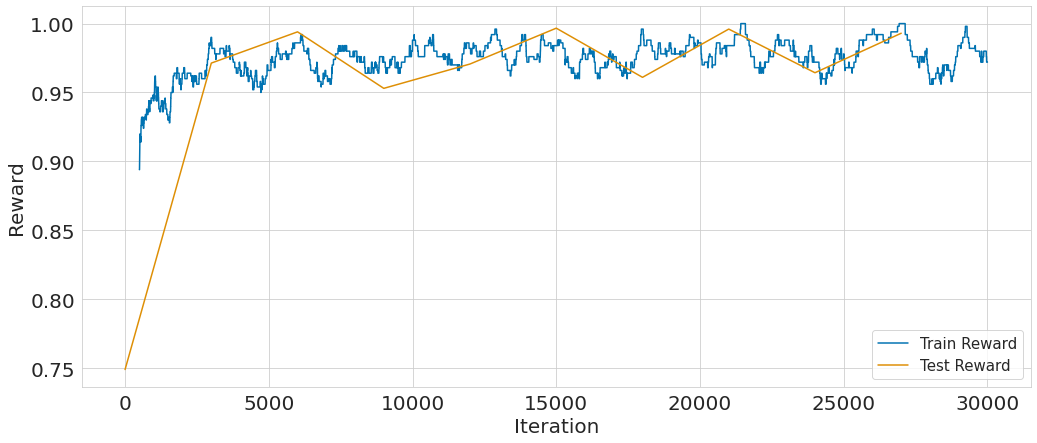

In [12]:
plot_train_reward(rewards_0, local_est_0)

In [13]:
crosses_q_learning_policy, noughts_q_learning_policy, rewards_1, local_est_1 = train_q_learning_policy_noughts(env, crosses_q_learning_policy,
                                                     noughts_q_learning_policy, 
                                                     30000, 0.5, 0.5)

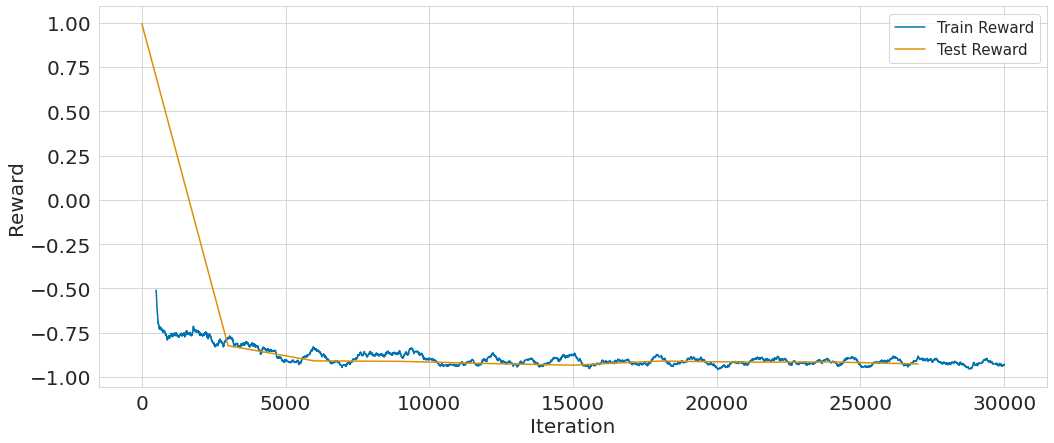

In [14]:
plot_train_reward(rewards_1, local_est_1)

In [15]:
crosses_q_learning_policy, noughts_q_learning_policy, rewards, local_est = train_q_learning_policy_crosses(env, crosses_q_learning_policy,
                                                     noughts_q_learning_policy, 
                                                     200000, 0.5, 0.5)

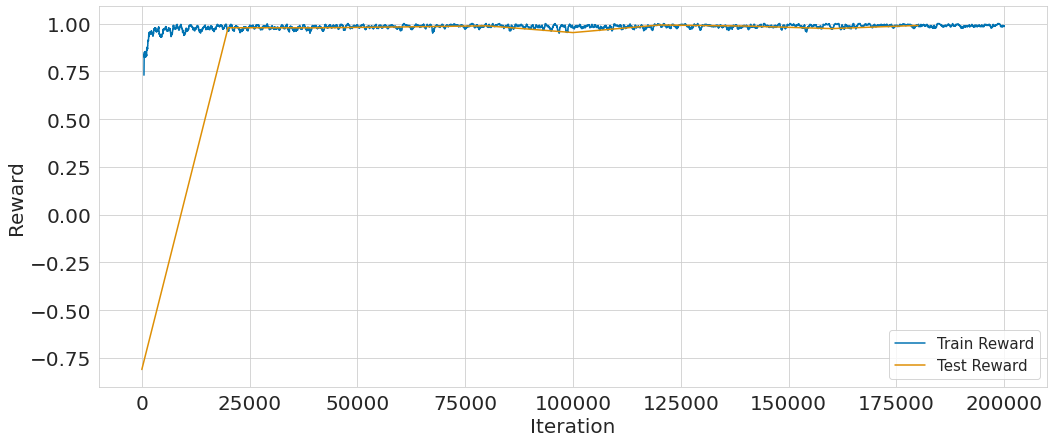

In [16]:
plot_train_reward(rewards, local_est)

In [17]:
def plot_board(env, pi, showtext=True, verbose=True, fontq=20, fontx=60):
    '''Рисуем доску с оценками из стратегии pi'''
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    X, Y = np.meshgrid(np.arange(0, env.n_rows), np.arange(0, env.n_rows))
    Z = np.zeros((env.n_rows, env.n_cols)) + .01
    s, actions = env.getHash(), env.getEmptySpaces()
    if pi is not None and s in pi._q_function:
        for i, a in enumerate(actions):
            Z[a[0], a[1]] = pi._q_function[s][i]
    ax.set_xticks([])
    ax.set_yticks([])
    surf = ax.imshow(Z, cmap=plt.get_cmap('Accent', 10), vmin=-1, vmax=1)
    if showtext:
        for i,a in enumerate(actions):
            if pi is not None and s in pi._q_function:
                ax.text( a[1] , a[0] , "%.3f" % pi._q_function[s][i], 
                        fontsize=fontq, horizontalalignment='center', verticalalignment='center', color="w" )
#             else:
#                 ax.text( a[1] , a[0] , "???", fontsize=fontq, horizontalalignment='center', verticalalignment='center', color="w" )
    for i in range(env.n_rows):
        for j in range(env.n_cols):
            if env.board[i, j] == -1:
                ax.text(j, i, "O", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
            if env.board[i, j] == 1:
                ax.text(j, i, "X", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
    cbar = plt.colorbar(surf, ticks=[0, 1])
    ax.grid(False)
    plt.show()


def get_and_print_move(env, pi, s, actions, random=False, verbose=True, fontq=20, fontx=60):
    '''Делаем ход, рисуем доску'''
    plot_board(env, pi, fontq=fontq, fontx=fontx)
    if verbose and (pi is not None):
        if s in pi._q_function:
            for i,a in enumerate(actions):
                print(i, a, pi._q_function[s][i])
        else:
            print("Стратегия не знает, что делать...")
    if random:
        return actions[np.random.randint(len(actions))]
    else:
        return pi.action(s, actions, train_mode=False)
    
    
def plot_test_game(env, pi1, pi2, random_crosses=True, random_naughts=True, verbose=True, fontq=20, fontx=60):
    '''Играем тестовую партию между стратегиями или со случайными ходами, рисуем ход игры'''
    done = False
    env.reset()
    while not done:
        s, actions = env.getHash(), env.getEmptySpaces()
        if env.curTurn == 1:
            action = get_and_print_move(env, pi1, s, actions, random=random_crosses, verbose=verbose, fontq=fontq, fontx=fontx)
        else:
            action = get_and_print_move(env, pi2, s, actions, random=random_naughts, verbose=verbose, fontq=fontq, fontx=fontx)
            
        observation, reward, done, info = env.step(action)
        
        if reward == 1:
            print("Крестики выиграли!")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)
        if reward == -1:
            print("Нолики выиграли!")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)

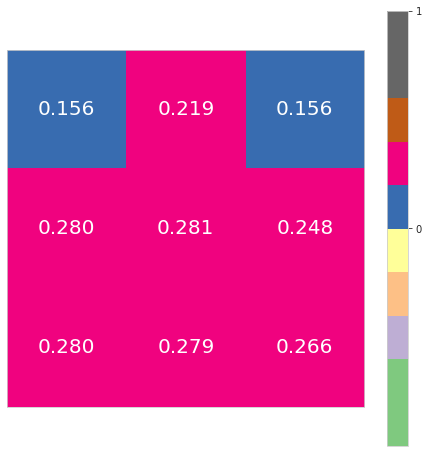

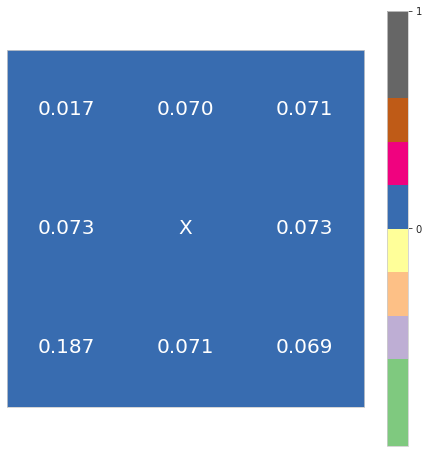

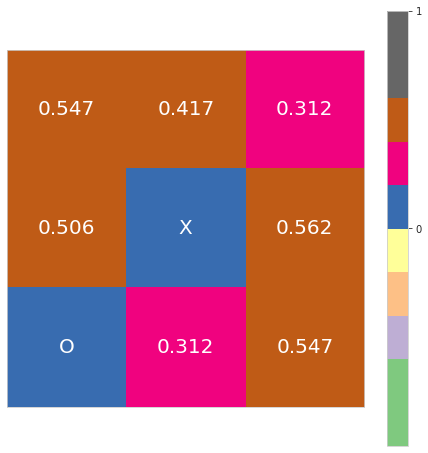

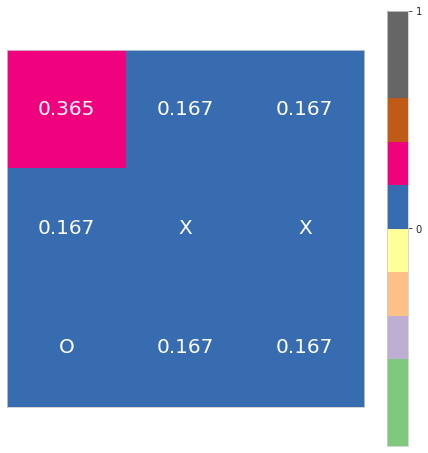

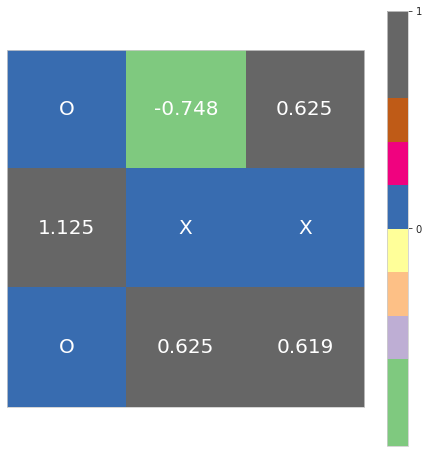

Крестики выиграли!


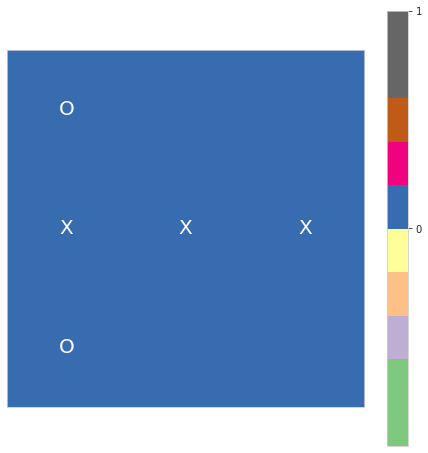

In [18]:
plot_test_game(env, crosses_q_learning_policy, noughts_q_learning_policy, random_crosses=False, 
               random_naughts=False, verbose=False, fontx=20)

#### 2. Попробуйте обучить стратегии крестиков и ноликов для доски 4х4 и/или 5х5.

In [175]:
env = TicTacToe(n_rows=4, n_cols=4, n_win=4)

crosses_q_learning_policy_ = QPolicy(env.n_rows, env.n_cols)
noughts_q_learning_policy_ = QPolicy(env.n_rows, env.n_cols)

In [176]:
crosses_q_learning_policy_, noughts_q_learning_policy_, rewards_0, local_est_0 = train_q_learning_policy_crosses(env, crosses_q_learning_policy_,
                                                     noughts_q_learning_policy_, 
                                                     30000, 0.05, 0.9)

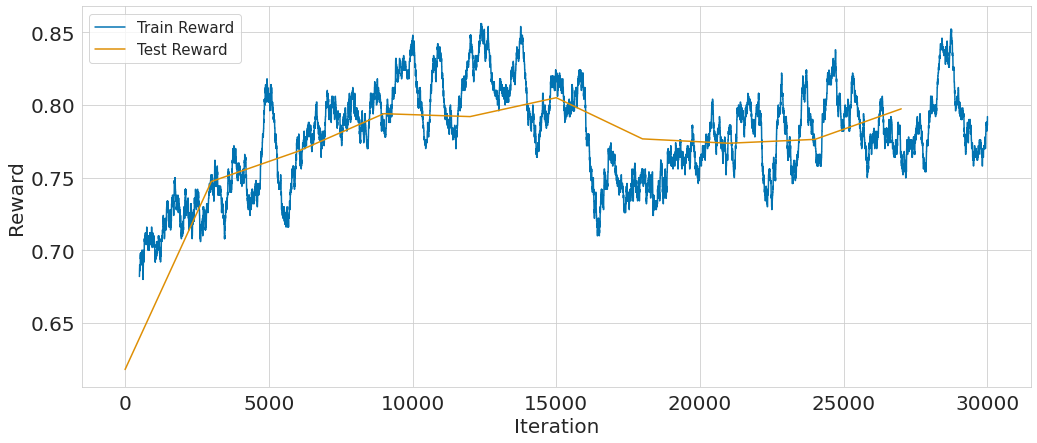

In [177]:
plot_train_reward(rewards_0, local_est_0)

In [178]:
crosses_q_learning_policy_, noughts_q_learning_policy_, rewards_1, local_est_1 = train_q_learning_policy_noughts(env, crosses_q_learning_policy_,
                                                     noughts_q_learning_policy_, 
                                                     30000, 0.05, 0.9)

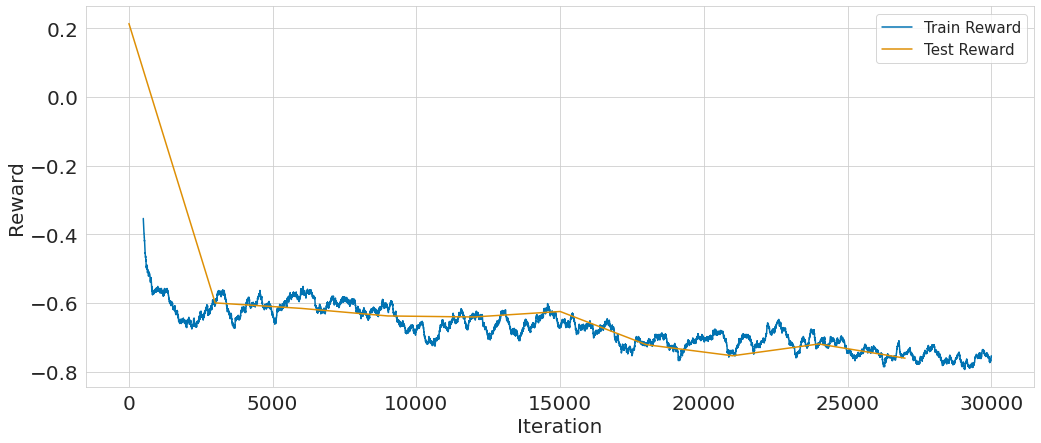

In [179]:
plot_train_reward(rewards_1, local_est_1)

In [180]:
crosses_q_learning_policy_, noughts_q_learning_policy_, rewards, local_est = train_q_learning_policy_crosses(env, crosses_q_learning_policy_,
                                                     noughts_q_learning_policy_, 
                                                     200000, 0.05, 0.9)

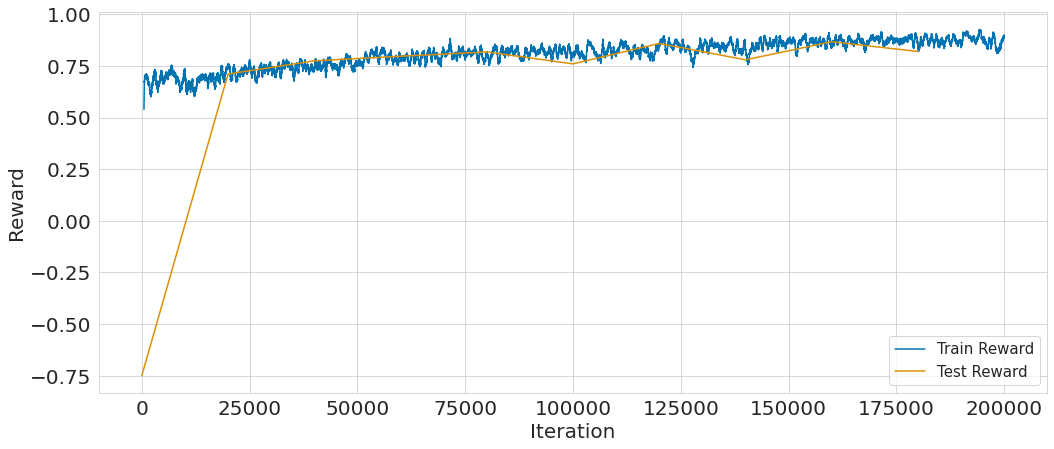

In [181]:
plot_train_reward(rewards, local_est)

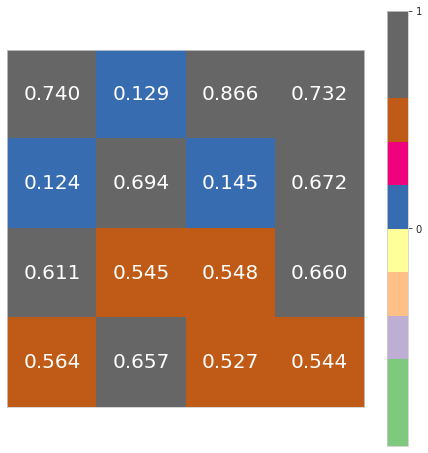

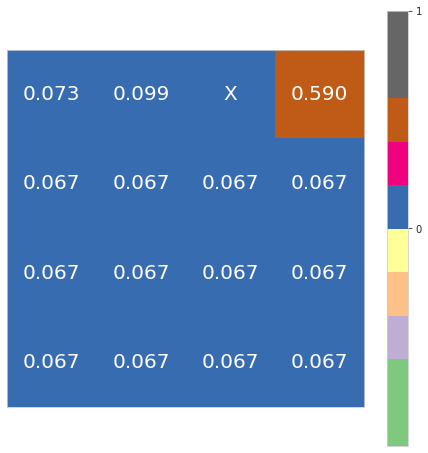

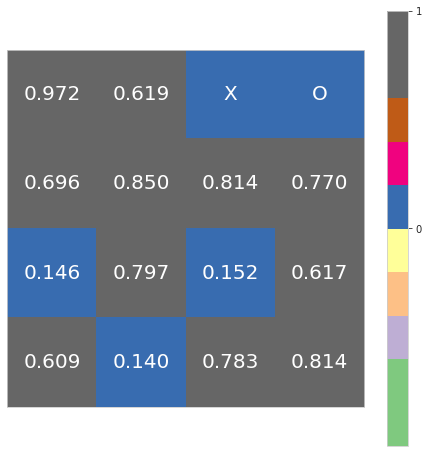

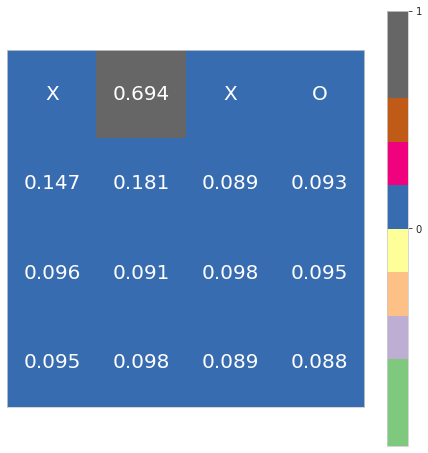

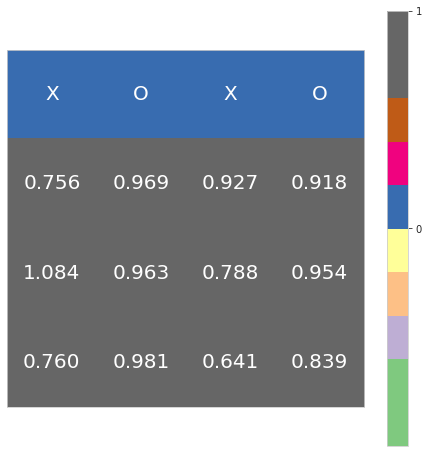

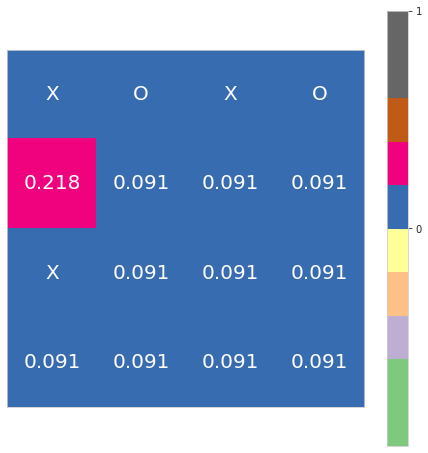

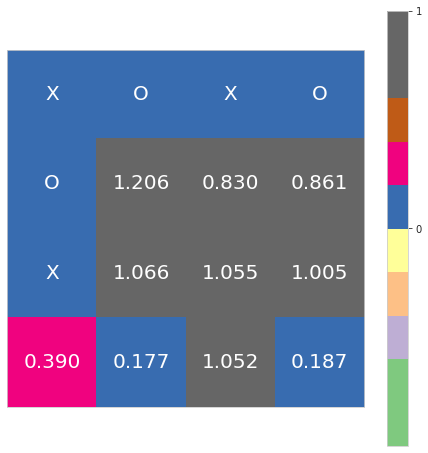

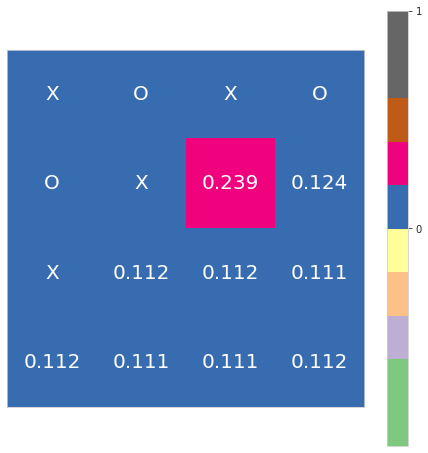

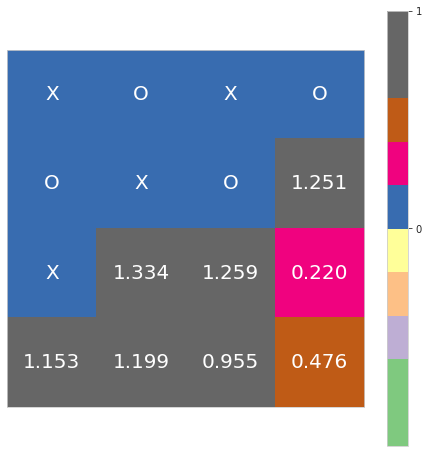

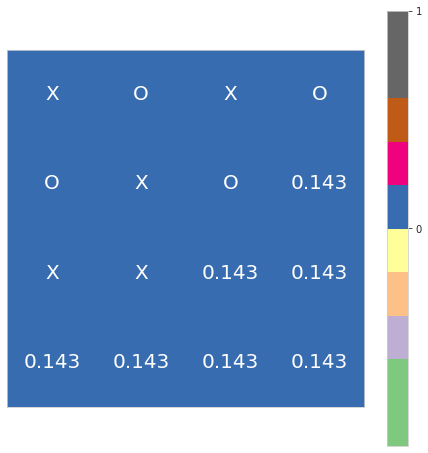

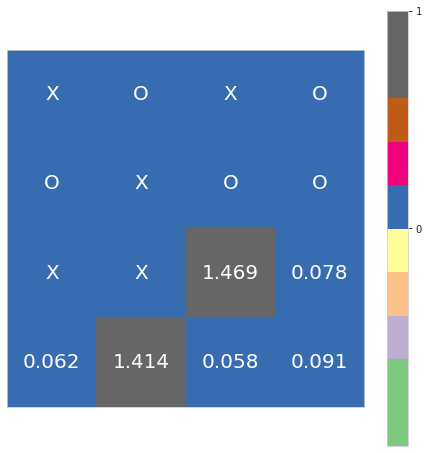

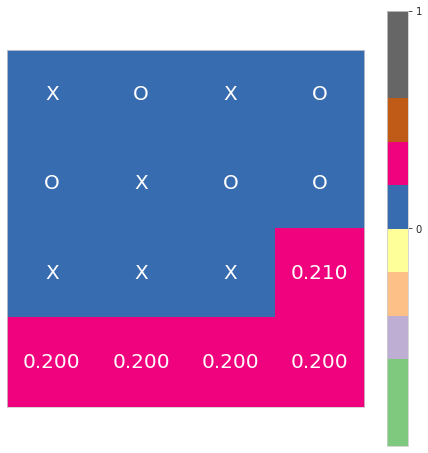

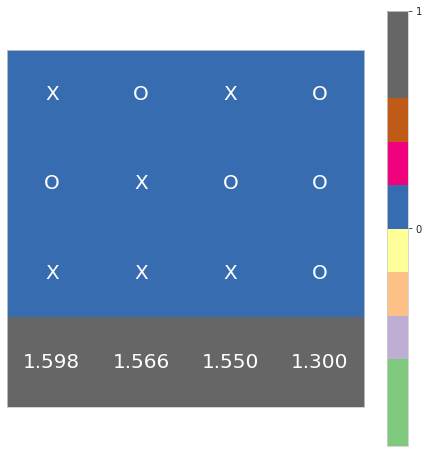

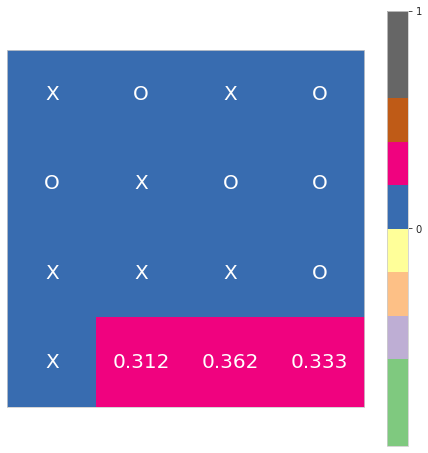

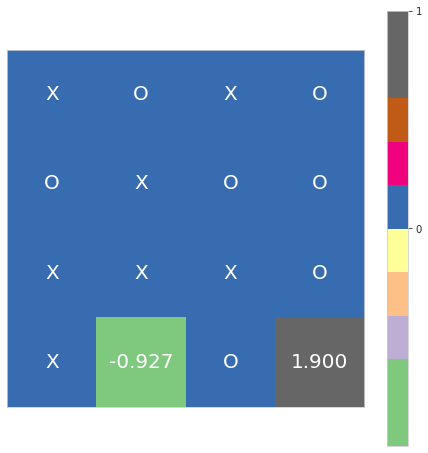

Крестики выиграли!


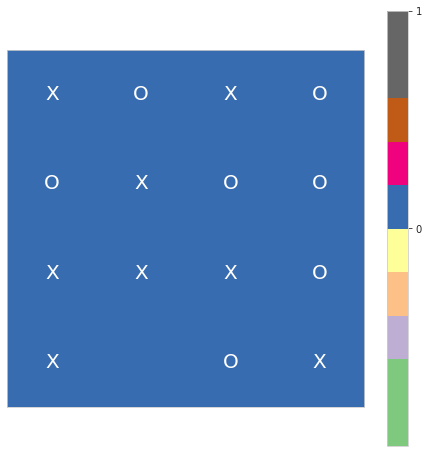

In [182]:
plot_test_game(env, crosses_q_learning_policy_, noughts_q_learning_policy_, random_crosses=False, 
               random_naughts=False, verbose=False, fontx=20)

Видно что и в случае доски 3x3 и 4X4 происходит постепенное обучение.
По-хорошему, нужно обучать попеременно крестики и нолики на играх друг с другом, уменьшая
параметр \epsilon в greedy. Но в данном пункте и в следующем
главной моей целью было проверить, что алгоритм работает и постепенно обучается.
Поэтому я фиксировал \epsilion и количество игра на каждой из итерации

### Часть вторая: добавим нейронных сетей

In [28]:
Transition = namedtuple('Transition',
                        ('state', 'actions', 'action', 'next_state', 'next_actions', 'reward'))

class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [29]:
class QN(nn.Module):
    def __init__(self, n_rows, n_cols, n_win):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.lin = nn.Linear(256, 128)
        self.head = nn.Linear(128, n_rows * n_cols)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.lin(x.view(x.size(0), -1)))
        return self.head(x)

In [30]:
def train_deep_double_q_learning_policy_crosses(env, crosses_policy, noughts_policy, n_games):
    """
    Q-learning training
    """
    rewards = []
    local_est = []
    # writer = SummaryWriter(f"runs/tensorboard")
    # step = 0
    
    for i in notebook.tqdm(range(n_games)):
        env.reset()
        done = False
        
        while True:
            observation, actions = env.getHash(), env.getEmptySpaces()
            action = crosses_policy.action(observation, actions, train_mode=True)
            _, reward, done, _ = env.step(action)
            
            if not done:
                other_observation, other_actions = env.getHash(), env.getEmptySpaces()
                other_action = noughts_policy.action(other_observation, other_actions, train_mode=True)
                _, other_reward, done, _ = env.step(other_action)
                reward += other_reward
            
            next_observation, next_actions = env.getHash(), env.getEmptySpaces()
            next_action = crosses_policy.action(next_observation, next_actions, train_mode=False)
            
            crosses_policy.replay_memory.push(observation, actions, action, 
                                              next_observation, next_actions, reward)
            if done:
                rewards.append(reward)
                break
                
            loss = crosses_policy.opt_step()
            
            # if loss:
            #     step += 1
            #     writer.add_scalar("Tranning Loss", loss, global_step=step)
            
        if i % int(n_games / 10) == 0:
            local_est.append((i, policy_estimation(env, crosses_policy, noughts_policy, int(n_games / 10))))
            
    return crosses_policy, noughts_policy, rewards, local_est

In [31]:
def train_deep_double_q_learning_policy_noughts(env, crosses_policy, noughts_policy, n_games):
    """
    Q-learning training
    """
    rewards = []
    local_est = []
    # writer = SummaryWriter(f"runs/tensorboard")
    # step = 0
    
    
    for i in notebook.tqdm(range(n_games)):
        env.reset()
        done = False
        
        observation, actions = env.getHash(), env.getEmptySpaces()
        action = crosses_policy.action(observation, actions, train_mode=True)
        _, reward, done, _ = env.step(action)
        
        while True:
            observation, actions = env.getHash(), env.getEmptySpaces()
            action = noughts_policy.action(observation, actions, train_mode=True)
            _, reward, done, _ = env.step(action)
            
            if not done:
                other_observation, other_actions = env.getHash(), env.getEmptySpaces()
                other_action = crosses_policy.action(other_observation, other_actions, train_mode=True)
                _, other_reward, done, _ = env.step(other_action)
                reward += other_reward
            
            next_observation, next_actions = env.getHash(), env.getEmptySpaces()
            next_action = noughts_policy.action(next_observation, next_actions, train_mode=False)
            
            noughts_policy.replay_memory.push(observation, actions, action, 
                                              next_observation, next_actions, -reward)
            if done:
                rewards.append(reward)
                break
                
            loss = noughts_policy.opt_step()

            
        if i % int(n_games / 10) == 0:
            local_est.append((i, policy_estimation(env, crosses_policy, noughts_policy, int(n_games / 10))))
            
    return crosses_policy, noughts_policy, rewards, local_est

In [32]:
def get_and_print_move(env, pi, s, actions, random=False, verbose=True, fontq=20, fontx=60):
    '''Делаем ход, рисуем доску'''
    plot_board(env, None, fontq=fontq, fontx=fontx)
    if random:
        return actions[np.random.randint(len(actions))]
    else:
        return pi.action(s, actions, train_mode=False)

def plot_test_game(env, pi1, pi2, random_crosses=True, random_naughts=True, verbose=True, fontq=20, fontx=60):
    '''Играем тестовую партию между стратегиями или со случайными ходами, рисуем ход игры'''
    done = False
    env.reset()
    while not done:
        s, actions = env.getHash(), env.getEmptySpaces()
        if env.curTurn == 1:
            action = get_and_print_move(env, pi1, s, actions, random=random_crosses, verbose=verbose, fontq=fontq, fontx=fontx)
        else:
            action = get_and_print_move(env, pi2, s, actions, random=random_naughts, verbose=verbose, fontq=fontq, fontx=fontx)
            
        observation, reward, done, info = env.step(action)
        
        if reward == 1:
            print("Крестики выиграли!")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)
        if reward == -1:
            print("Нолики выиграли!")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)

In [33]:
class BasePolicy:
    np.random.seed(42)
    def __init__(self, n_rows, n_cols, n_win, gamma=0.95, cache_size=50000):
        self._device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        self.policy_net = QN(n_rows, n_cols, n_win).to(self._device)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=3e-5)
        self.loss = nn.MSELoss()
        
        self.target_net = QN(n_rows, n_cols, n_win).to(self._device)
        self.policy_net.train()
        self.target_net.train()
        
        self._gamma = gamma
        self.replay_memory = ReplayMemory(cache_size)
        self._n_rows = n_rows
        self._n_cols = n_cols
        self._target_net_counter_copy = 0
        self.eps_greedy_threshold = 0.05
        
    def state_to_array(self, state_hash):
        state_array = np.array(list(state_hash)).astype(int)
        state_array = state_array.reshape((self._n_rows, self._n_cols))
        torch_state_array = torch.from_numpy(state_array).unsqueeze(0).unsqueeze(0).float().to(self._device)
        return torch_state_array
        
    def action(self, observation, actions, train_mode=False):
        if len(actions) == 0:
            return None
        
        self.policy_net.eval()
        torch_state_array = self.state_to_array(observation)
        possible_actions_ind = actions[:, 0] * n_cols + actions[:, 1]
        q_val = self.policy_net(torch_state_array)
        q_val = q_val.detach().cpu().numpy().reshape(-1)
        q_val_ = q_val[possible_actions_ind]
        
        if train_mode & (random.random() < self.eps_greedy_threshold):
            return actions[np.random.choice(np.arange(actions.shape[0]), p=softmax(q_val_))]
        else:
            return actions[np.argmax(q_val_)]

#### 3. Реализуйте DQN с нейронной сетью, обучите стратегии крестиков и ноликов. Замечание: скорее всего, experience replay потребуется сразу же.

In [34]:
class DQPolicy(BasePolicy):
    def opt_step(self, batch_size=128):
        if len(self.replay_memory) < batch_size:
            return

        transitions = self.replay_memory.sample(batch_size)
        transitions = list(filter(lambda x: len(x.next_actions) > 0, transitions))

        batch = Transition(*zip(*transitions))

        states = torch.cat([self.state_to_array(s) for s in batch.state if s is not None])
        next_states = torch.cat([self.state_to_array(s) for s in batch.next_state if s is not None])

        self.policy_net.train()
        self.target_net.train()

        ###########################################################################################

        action_ind_in_state = [x[0] * n_cols + x[1] for x in batch.action]
        action_ind_in_state_torch = torch.tensor(action_ind_in_state).to(self._device).unsqueeze(1)

        q_vals_states = self.policy_net(states)
        q_vals_states_action = torch.gather(q_vals_states, 1, action_ind_in_state_torch)
        # определяем текущее предсказание q знчений

        possible_actions_ind_next_states = [x[:, 0] * n_cols + x[:, 1] for x in batch.next_actions]

        target_q_values_next_states = self.target_net(next_states)
        target_q_values_next_states_ = target_q_values_next_states.detach().cpu().numpy()

        best_policy_action = [np.argmax(x[y]) for x, y in zip(target_q_values_next_states_,
                                                              possible_actions_ind_next_states)]
        best_policy_action = torch.tensor(best_policy_action).to(self._device).unsqueeze(1)

        q_vals_next_states = torch.gather(target_q_values_next_states, 1, best_policy_action)

        batch_rewards = torch.tensor(batch.reward).to(self._device).unsqueeze(1)

        pred_q_vals = batch_rewards + self._gamma * q_vals_next_states

        loss = self.loss(q_vals_states_action, pred_q_vals)

        self.optimizer.zero_grad()
        loss.backward()
        for param in self.policy_net.parameters():
            param.grad.data.clamp_(-1, 1)

        self.optimizer.step()

        self._target_net_counter_copy += 1
        if self._target_net_counter_copy > 2:
            self._target_net_counter_copy = 0
            self.target_net.load_state_dict(self.policy_net.state_dict())

        return loss.item()

In [35]:
n_rows = 4
n_cols = 4
n_win = 4
gamma = 0.7

env = TicTacToe(n_rows=n_rows, n_cols=n_cols, n_win=n_win)
crosses_policy_dqlp = DQPolicy(n_rows, n_cols, n_win, gamma)
noughts_policy_dqlp = DQPolicy(n_rows, n_cols, n_win, gamma)

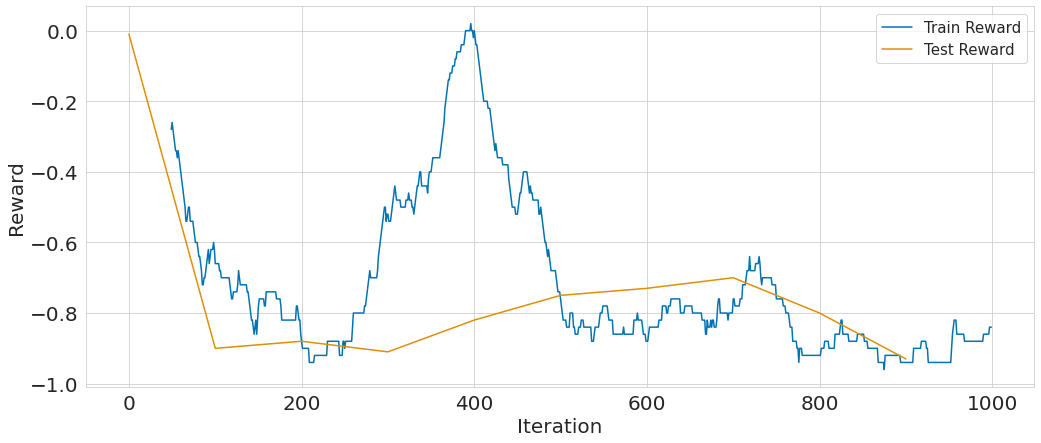

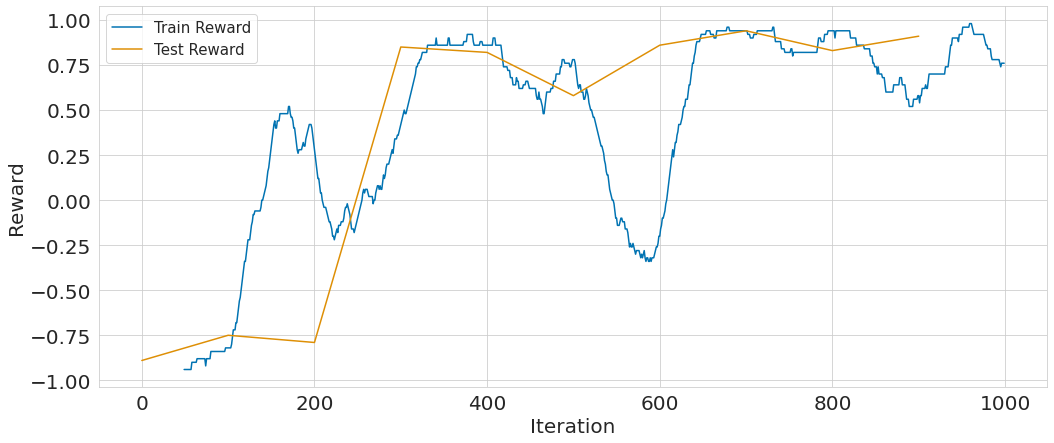

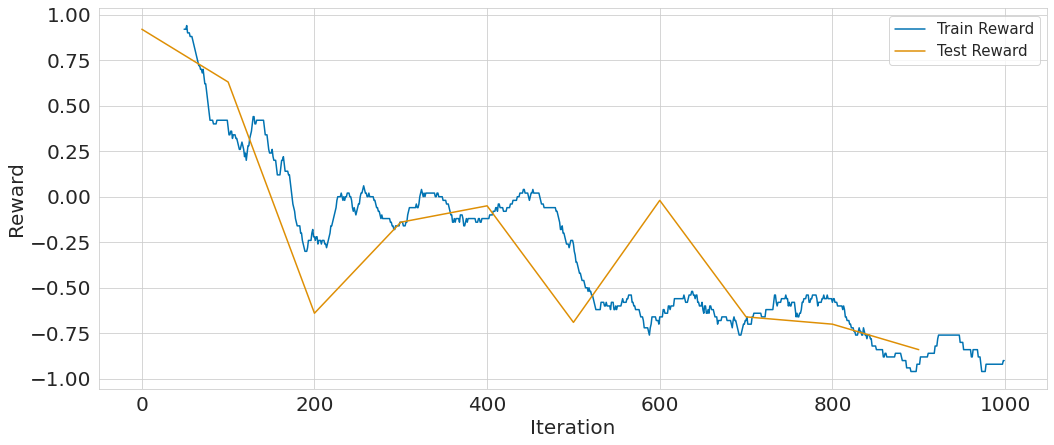

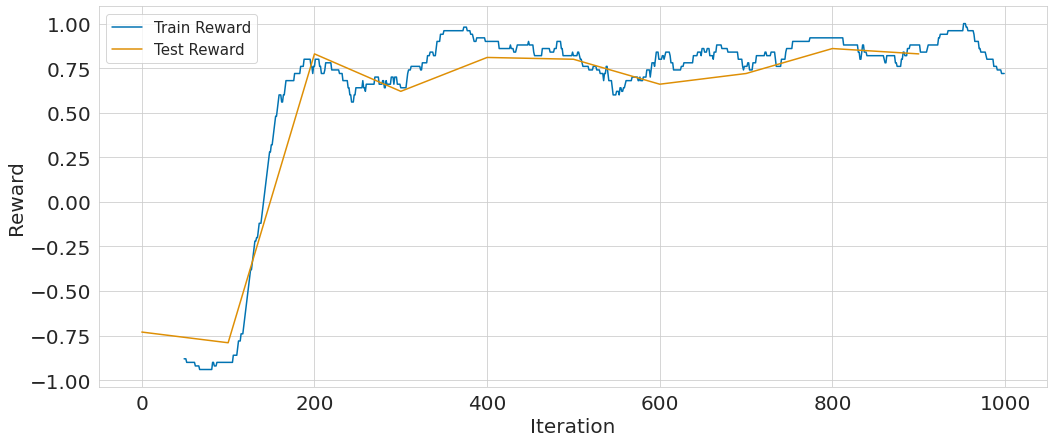

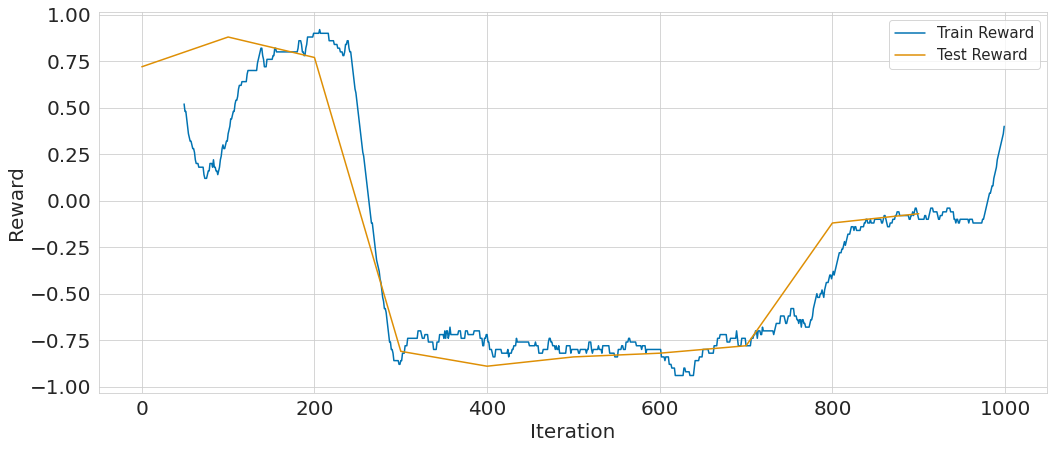

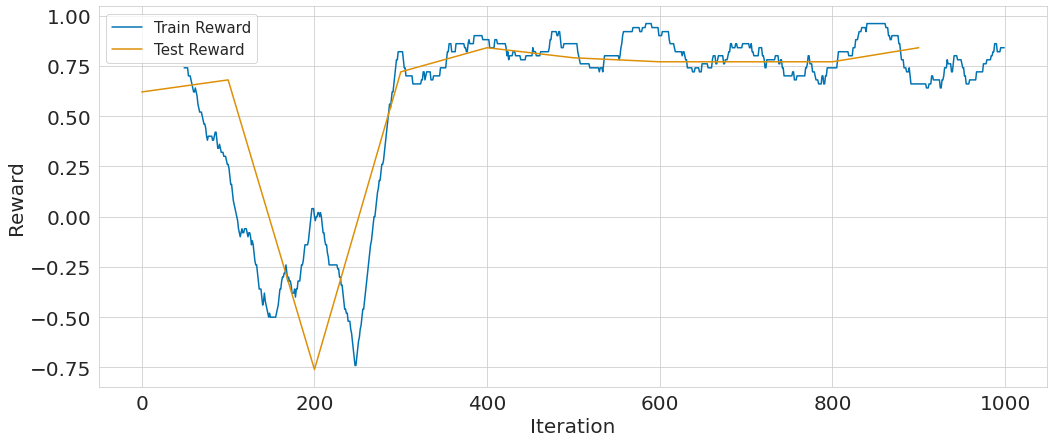

In [36]:
# tensorboard --logdir='./runs'

for i in range(3):
    crosses_policy_dqlp, noughts_policy_dqlp, rewards_, local_est_ = train_deep_double_q_learning_policy_noughts(env,
                                                                                                       crosses_policy_dqlp,
                                                                                                       noughts_policy_dqlp,
                                                                                                       1000)
    plot_train_reward(rewards_, local_est_, rolling_window=50)
    
    crosses_policy_dqlp, noughts_policy_dqlp, rewards_, local_est_ = train_deep_double_q_learning_policy_crosses(env,
                                                                                                       crosses_policy_dqlp,
                                                                                                       noughts_policy_dqlp,
                                                                                                       1000)

    plot_train_reward(rewards_, local_est_, rolling_window=50)

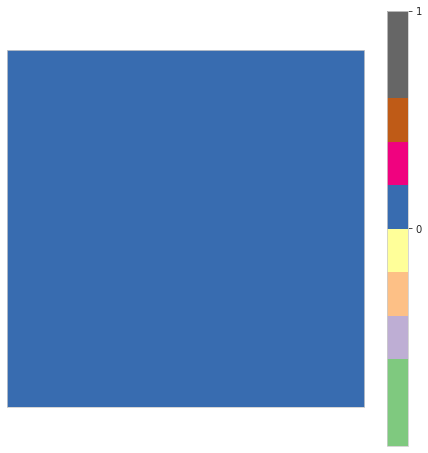

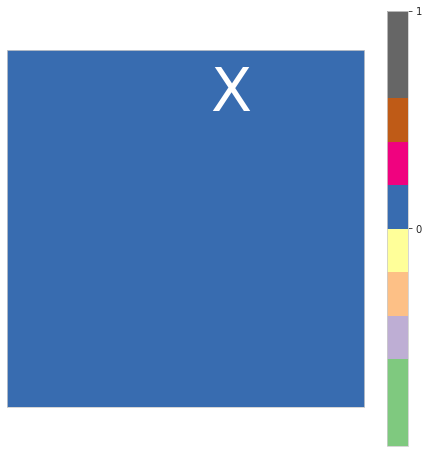

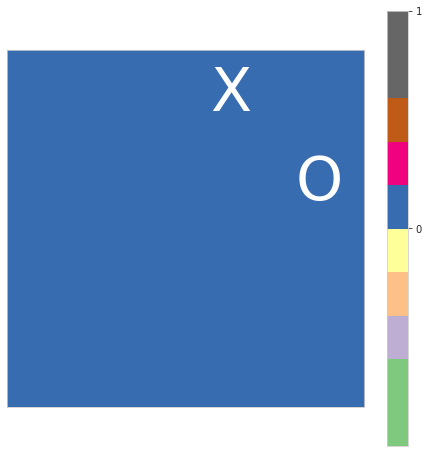

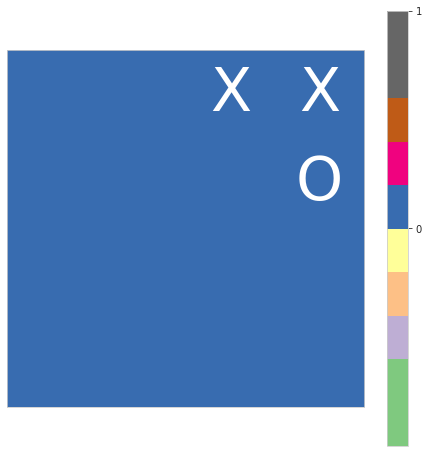

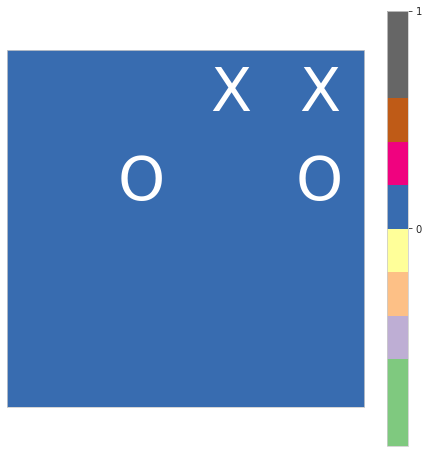

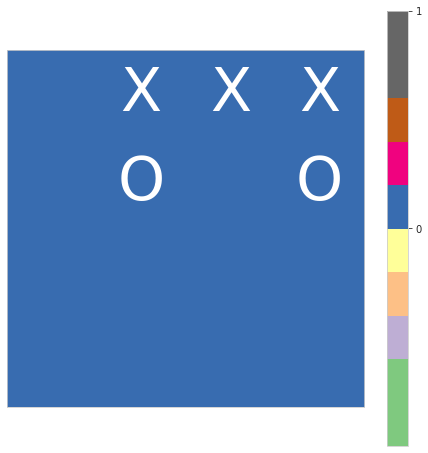

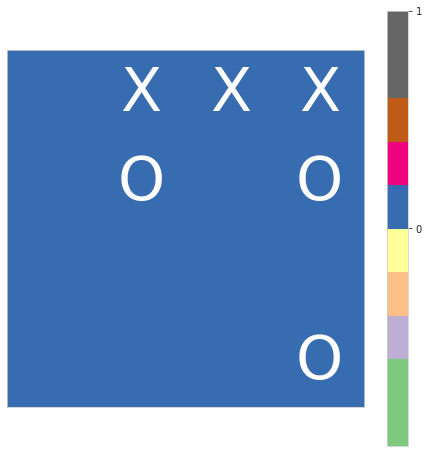

Крестики выиграли!


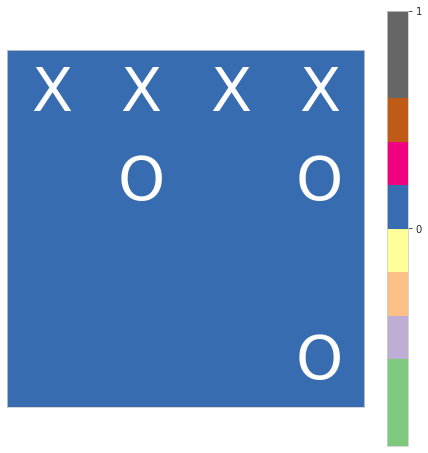

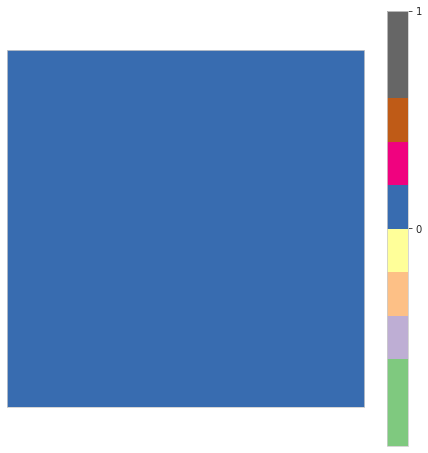

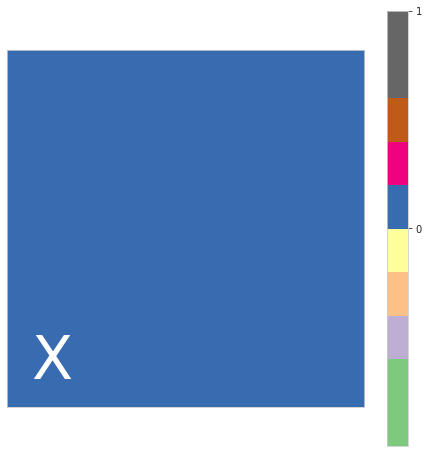

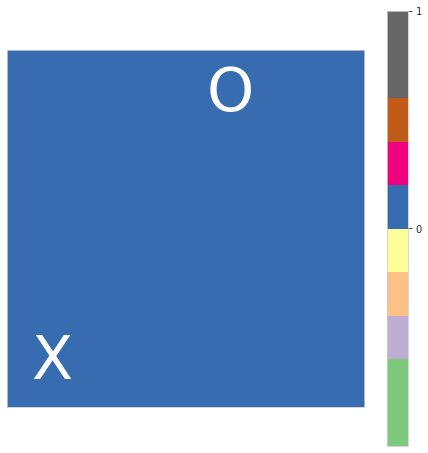

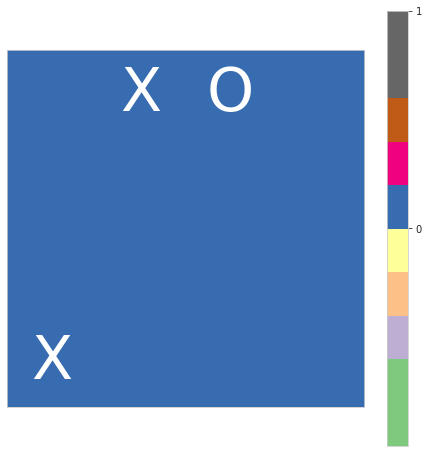

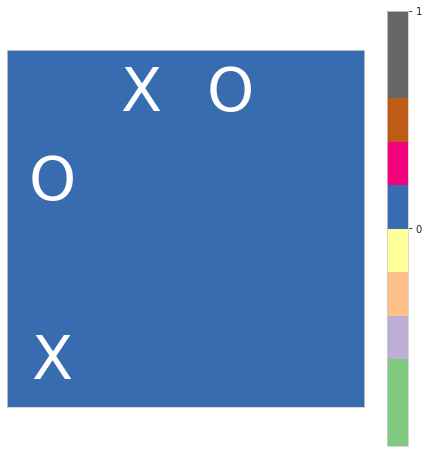

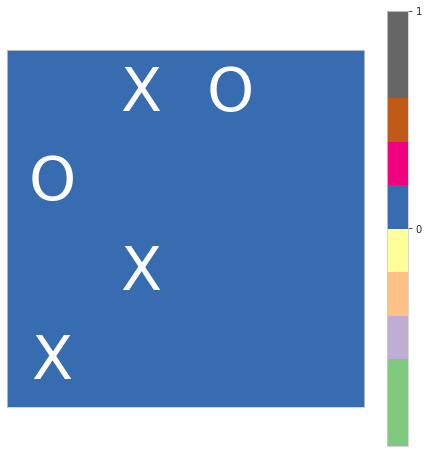

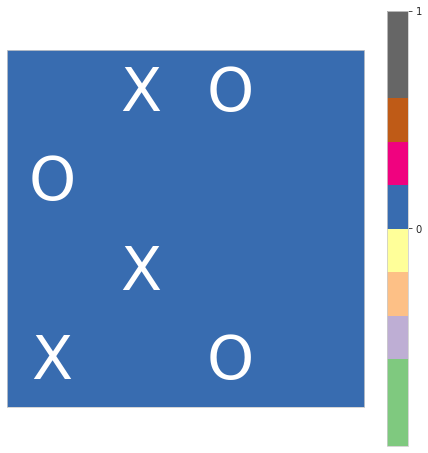

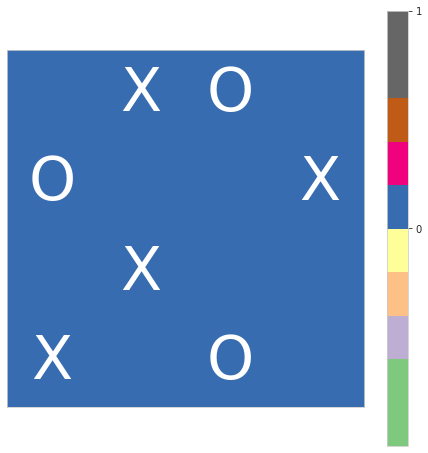

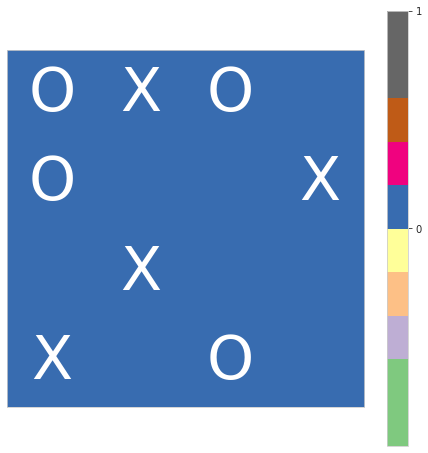

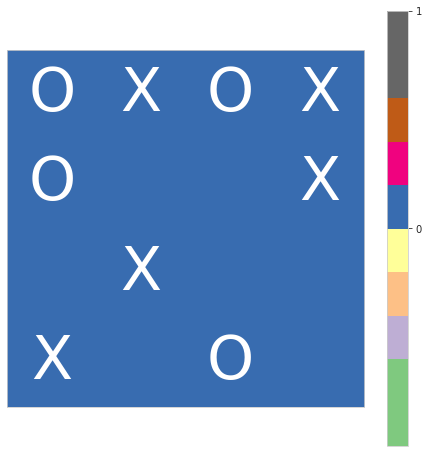

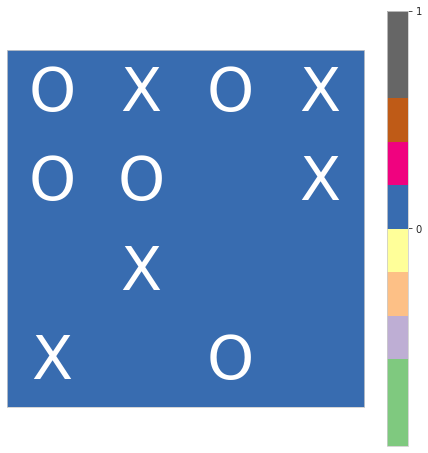

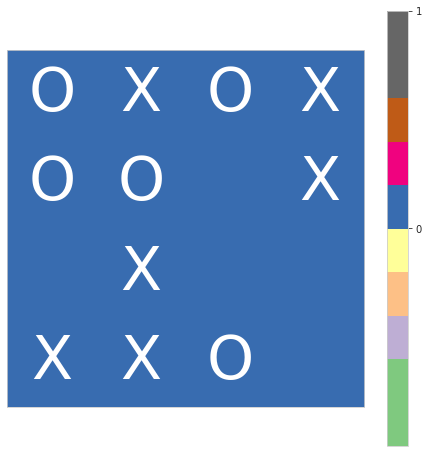

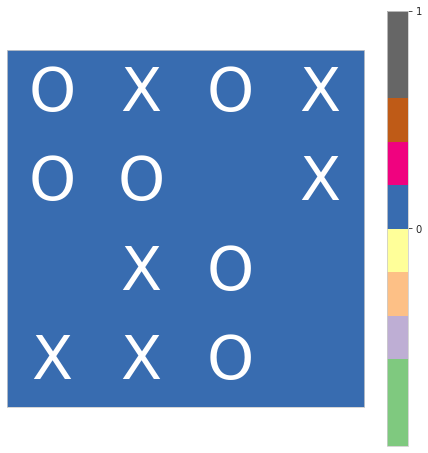

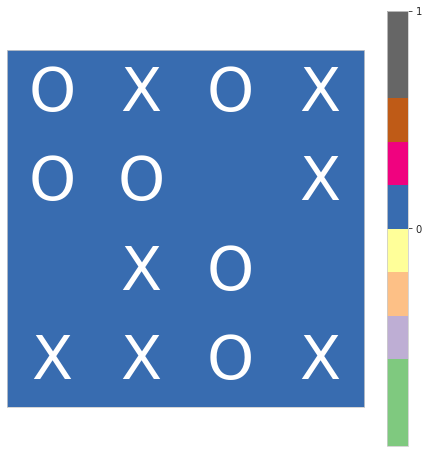

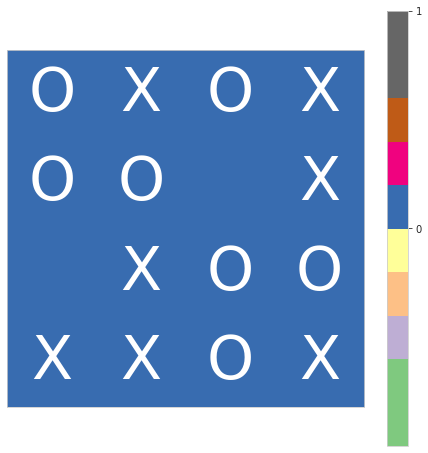

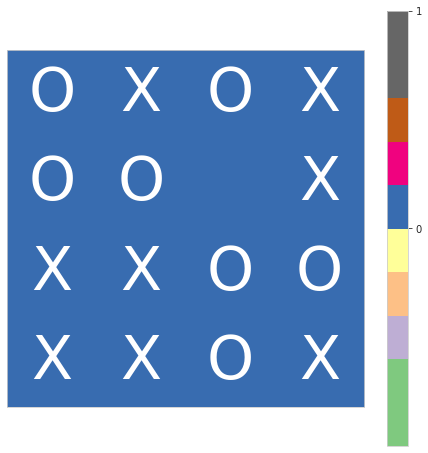

Нолики выиграли!


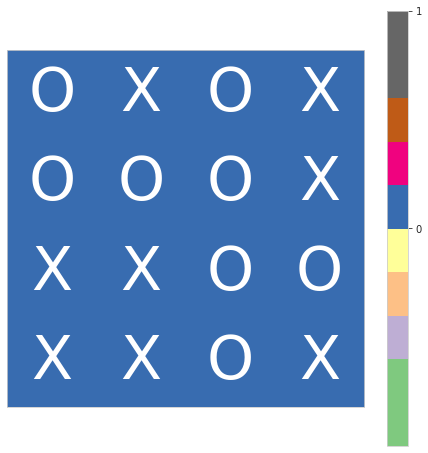

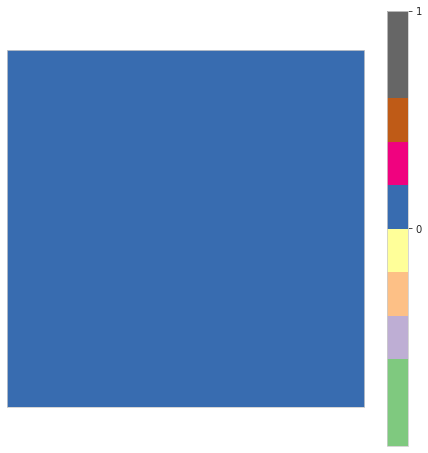

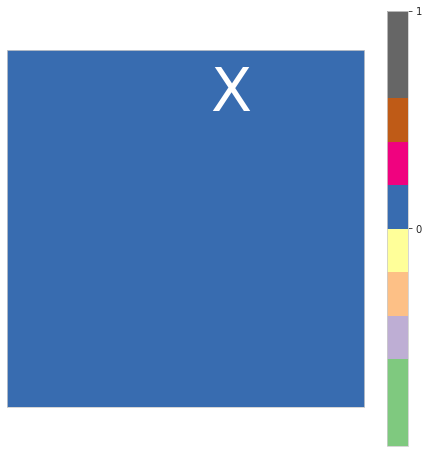

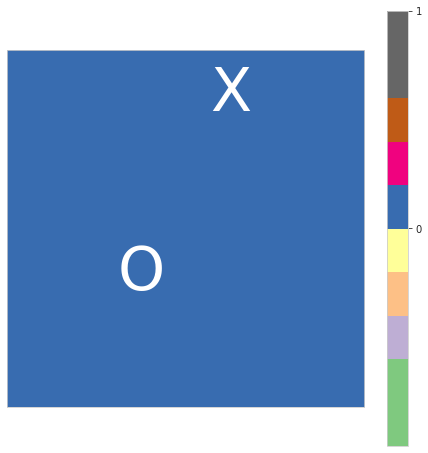

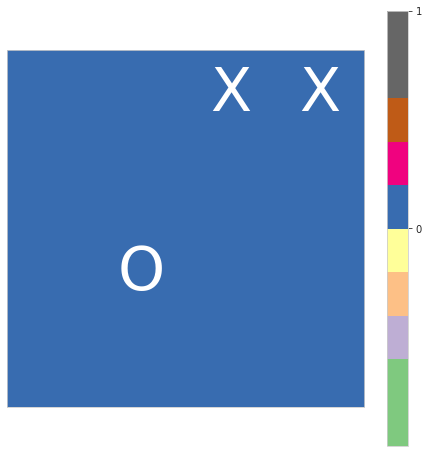

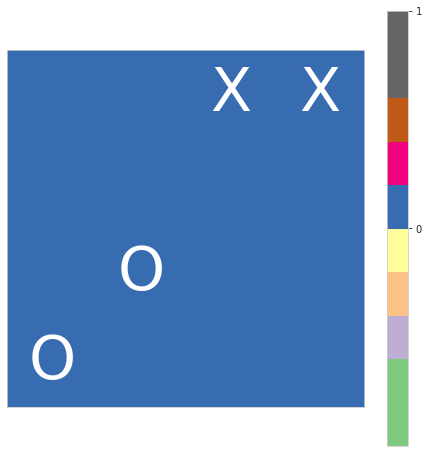

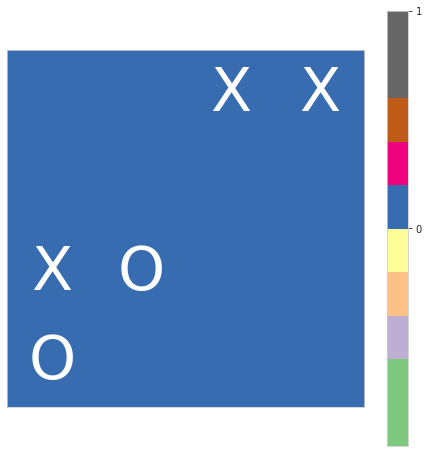

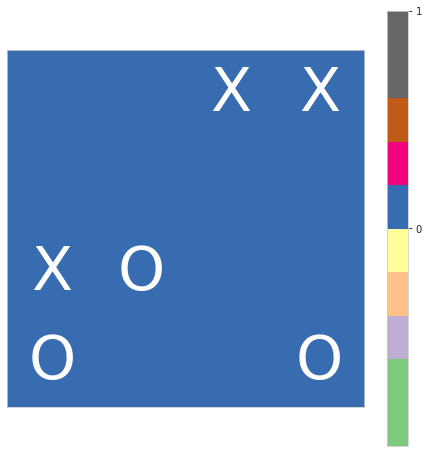

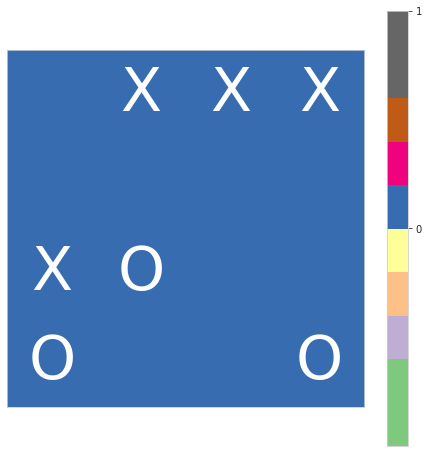

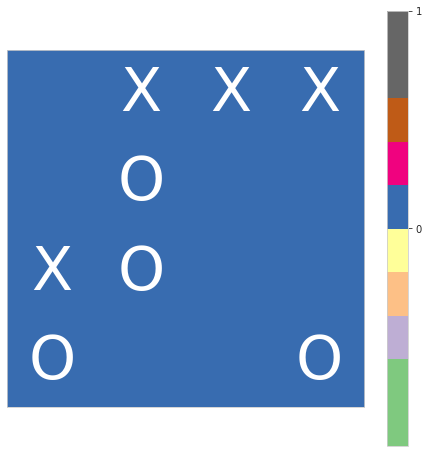

Крестики выиграли!


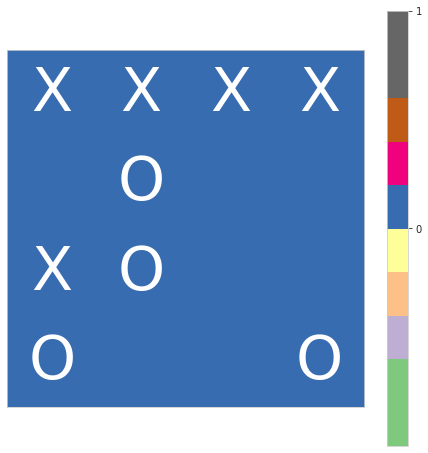

In [37]:
plot_test_game(env, crosses_policy_dqlp, None, random_crosses=False, random_naughts=True)

plot_test_game(env, None, noughts_policy_dqlp, random_crosses=True, random_naughts=False)

plot_test_game(env, crosses_policy_dqlp, noughts_policy_dqlp, random_crosses=False, random_naughts=False)

#### 4. Реализуйте Double DQN и/или Dueling DQN.

In [38]:
class DoubleDQPolicy(BasePolicy):        
    def opt_step(self, batch_size=128):
        if len(self.replay_memory) < batch_size:
            return

        transitions = self.replay_memory.sample(batch_size)
        transitions = list(filter(lambda x: len(x.next_actions) > 0, transitions))

        batch = Transition(*zip(*transitions))
        
        states = torch.cat([self.state_to_array(s) for s in batch.state if s is not None])
        next_states = torch.cat([self.state_to_array(s) for s in batch.next_state if s is not None])

        self.policy_net.train()
        self.target_net.train()
        
        ###########################################################################################

        action_ind_in_state = [x[0] * n_cols + x[1] for x in batch.action]
        action_ind_in_state_torch = torch.tensor(action_ind_in_state).to(self._device).unsqueeze(1)
        
        q_vals_states = self.policy_net(states)
        q_vals_states_action = torch.gather(q_vals_states, 1, action_ind_in_state_torch)
        # определяем текущее предсказание q знчений
        
        
        possible_actions_ind_next_states = [x[:, 0] * n_cols + x[:, 1] for x in batch.next_actions]
        # все возможные дествия в следующем состоянии

        policy_q_values_next_states = self.policy_net(next_states)
        policy_q_values_next_states_ = policy_q_values_next_states.detach().cpu().numpy()
        # получили q функцию 
        best_policy_action = [np.argmax(x[y]) for x, y in zip(policy_q_values_next_states_,
                                                              possible_actions_ind_next_states)]
        best_policy_action = torch.tensor(best_policy_action).to(self._device).unsqueeze(1)
        # выбрали лучшее действие

        target_q_values_next_states = self.target_net(next_states)
        q_vals_next_states = torch.gather(target_q_values_next_states, 1, best_policy_action)
         # получили q значения из target сети для действий из policy сети
        
        batch_rewards = torch.tensor(batch.reward).to(self._device).unsqueeze(1)

        pred_q_vals = batch_rewards + self._gamma * q_vals_next_states

        loss = self.loss(q_vals_states_action, pred_q_vals)
        
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.policy_net.parameters():
            param.grad.data.clamp_(-1, 1)
    
        self.optimizer.step()

        self._target_net_counter_copy += 1
        if self._target_net_counter_copy > 2:
            self._target_net_counter_copy = 0
            self.target_net.load_state_dict(self.policy_net.state_dict())
            
        return loss.item()

In [39]:
n_rows = 4
n_cols = 4
n_win = 4
gamma = 0.7

env = TicTacToe(n_rows=n_rows, n_cols=n_cols, n_win=n_win)
crosses_policy_ddqlp = DoubleDQPolicy(n_rows, n_cols, n_win, gamma)
noughts_policy_ddqlp = DoubleDQPolicy(n_rows, n_cols, n_win, gamma)

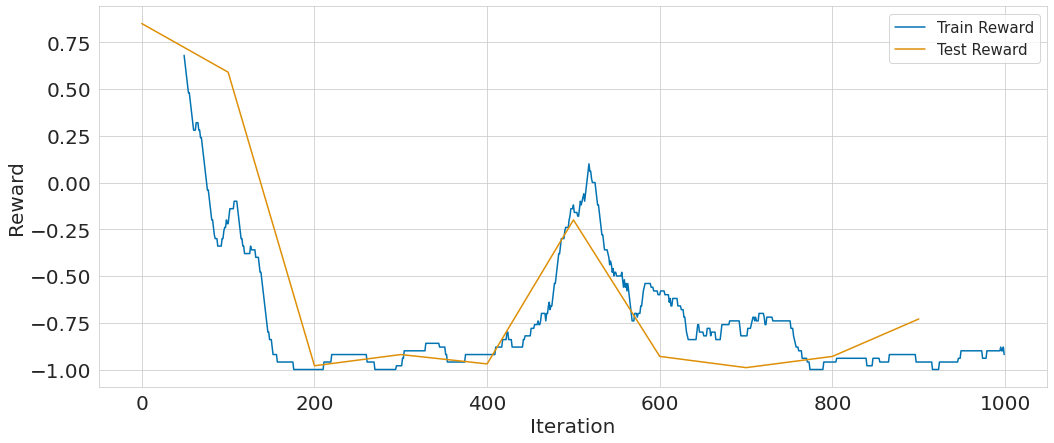

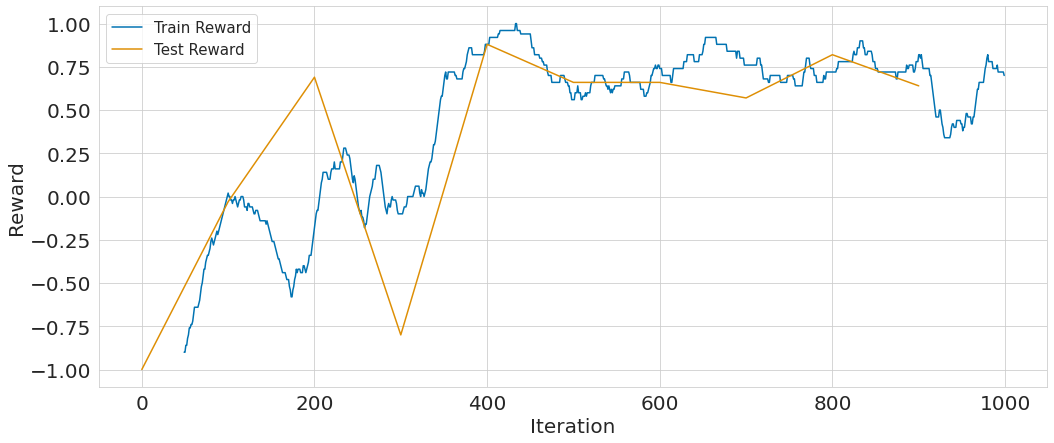

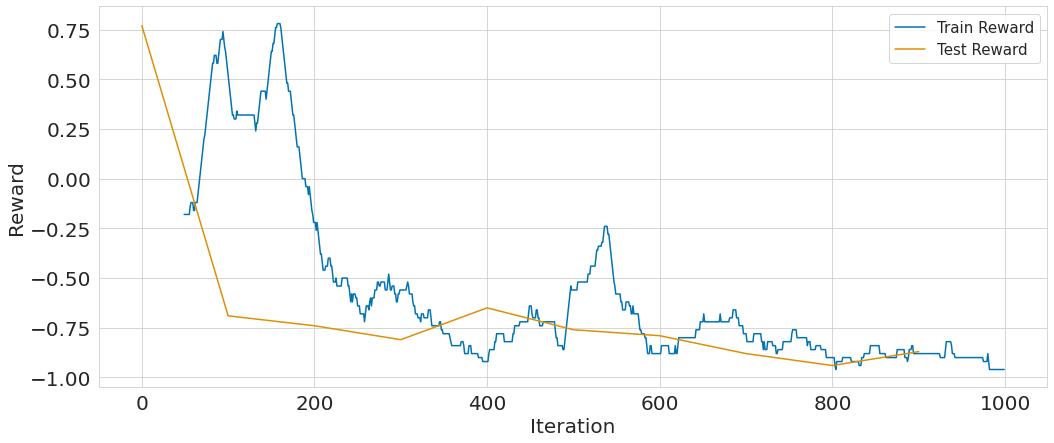

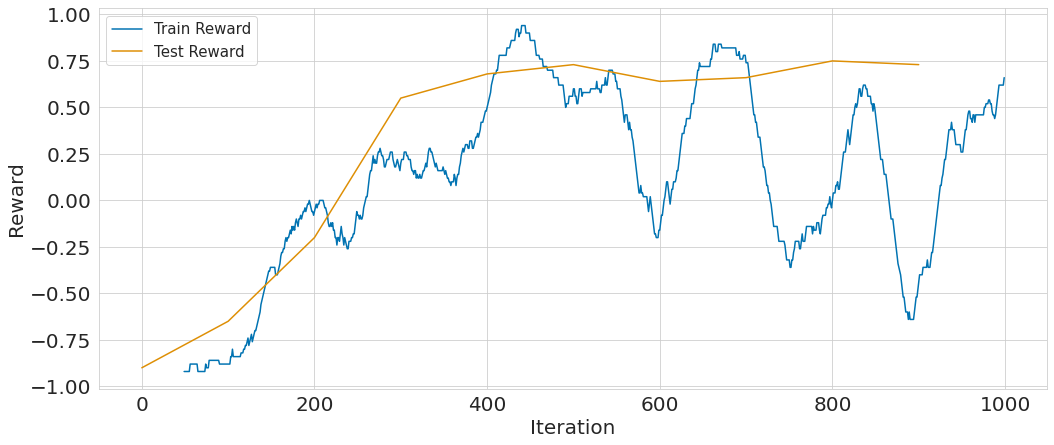

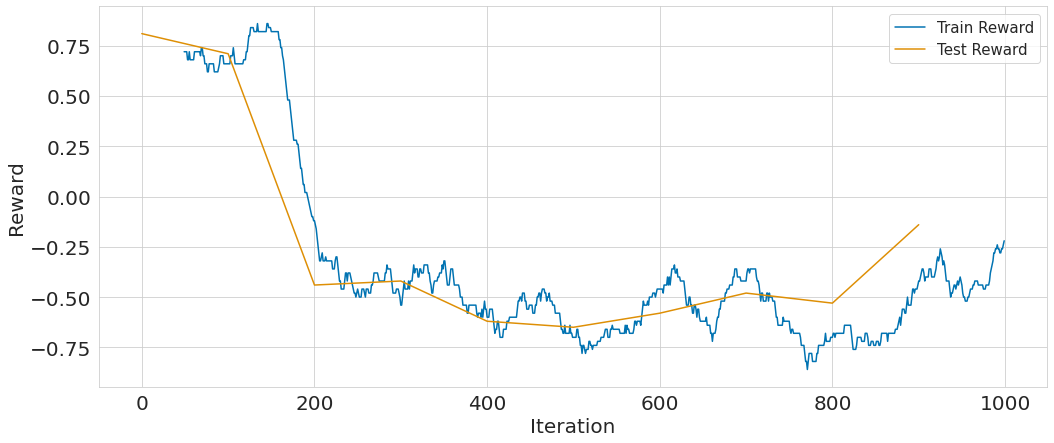

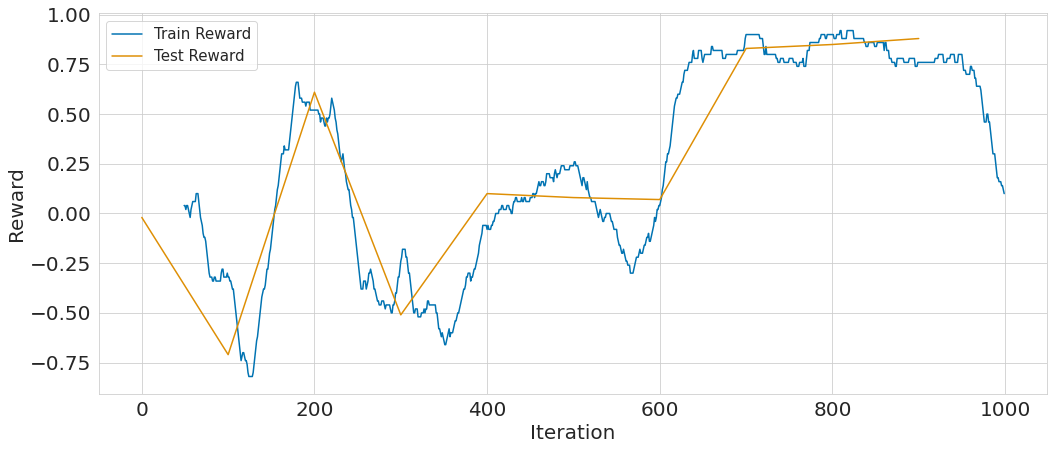

In [40]:
rewards_list = []
local_est_list = []
# tensorboard --logdir='./runs'

for i in range(3):
    crosses_policy_ddqlp, noughts_policy_ddqlp, rewards_, local_est_ = train_deep_double_q_learning_policy_noughts(env,
                                                                                                       crosses_policy_ddqlp,
                                                                                                       noughts_policy_ddqlp,
                                                                                                       1000)
    plot_train_reward(rewards_, local_est_, rolling_window=50)
    
    crosses_policy_ddqlp, noughts_policy_ddqlp, rewards_, local_est_ = train_deep_double_q_learning_policy_crosses(env,
                                                                                                       crosses_policy_ddqlp,
                                                                                                       noughts_policy_ddqlp,
                                                                                                       1000)
    plot_train_reward(rewards_, local_est_, rolling_window=50)

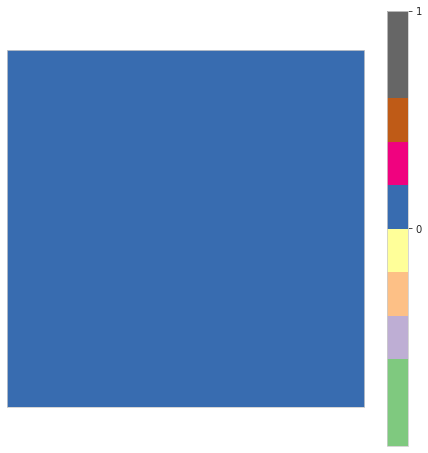

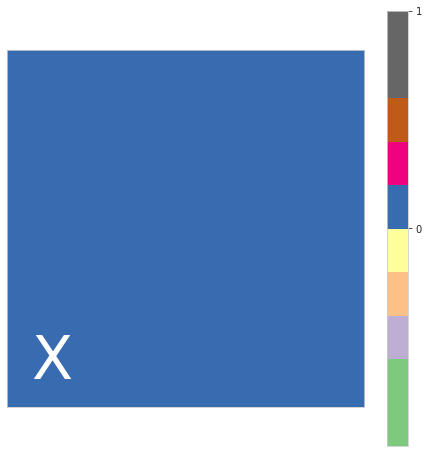

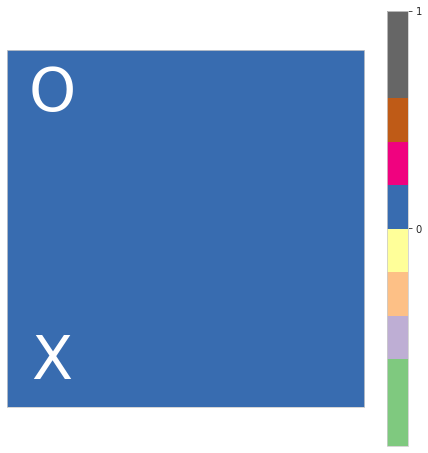

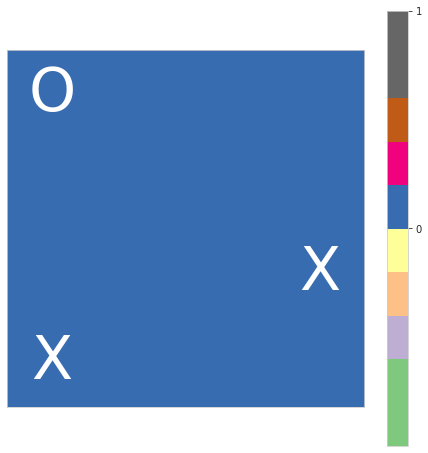

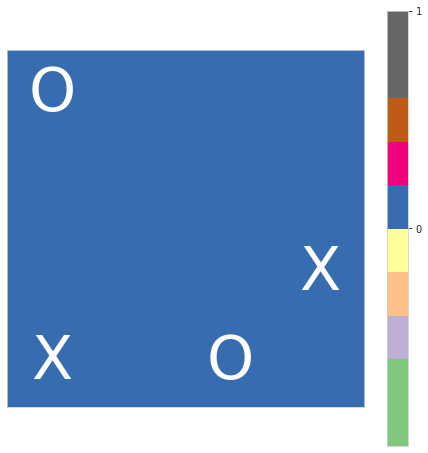

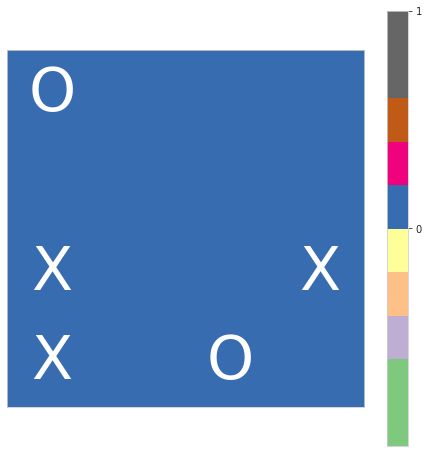

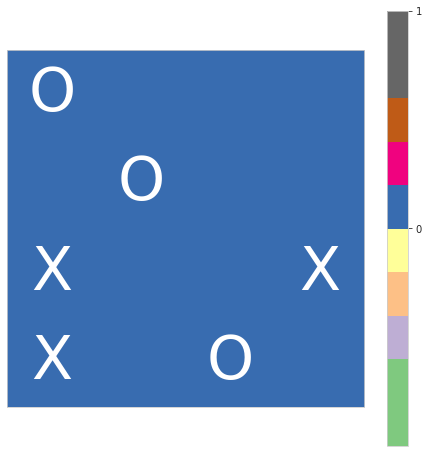

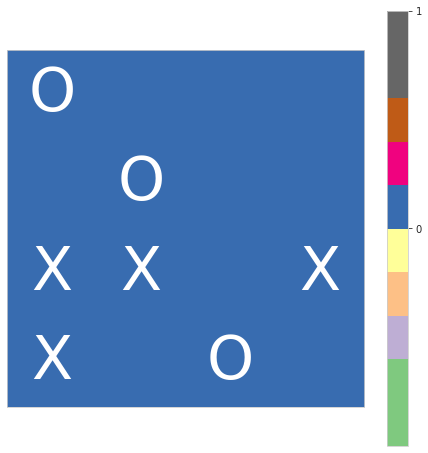

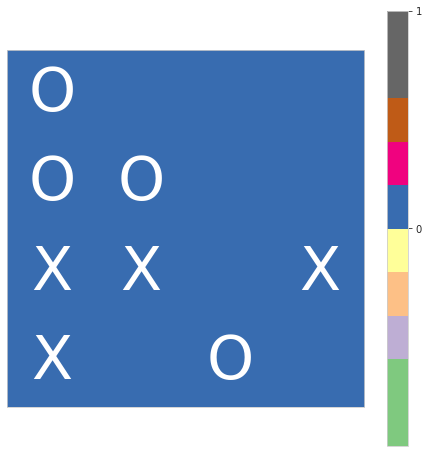

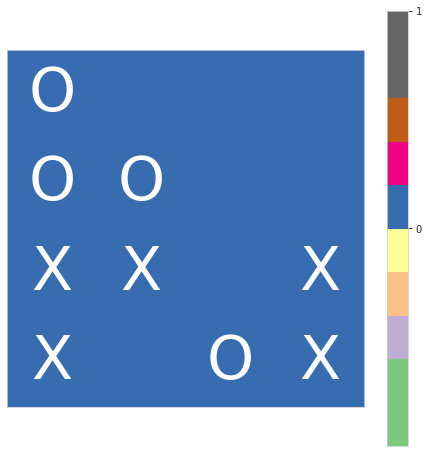

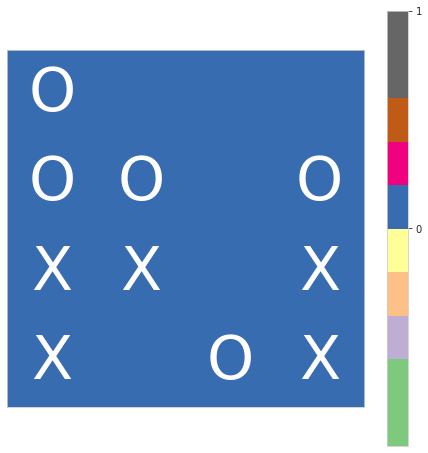

Крестики выиграли!


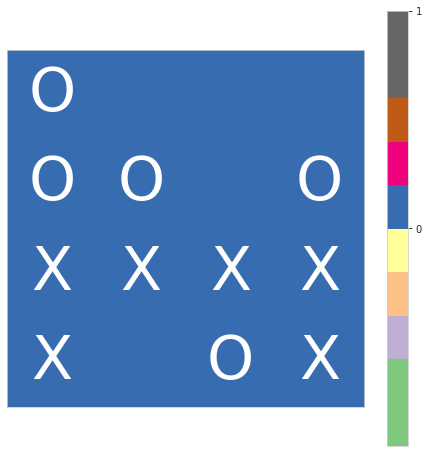

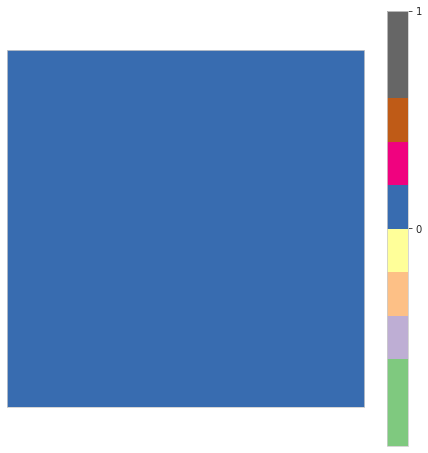

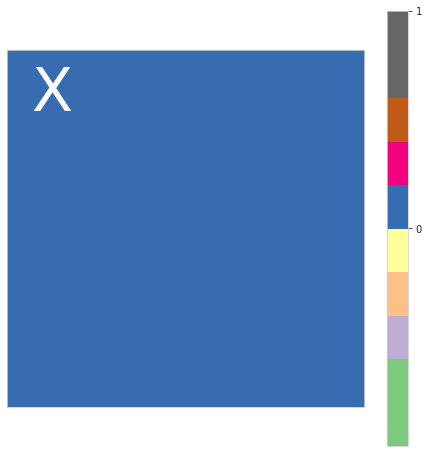

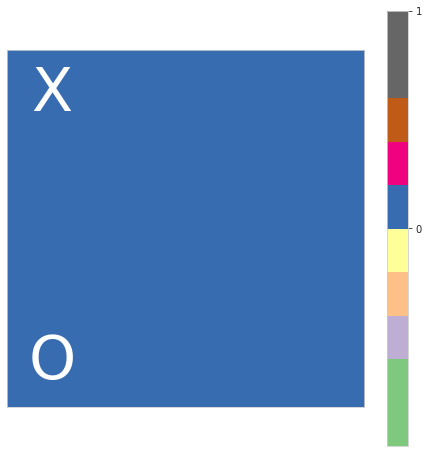

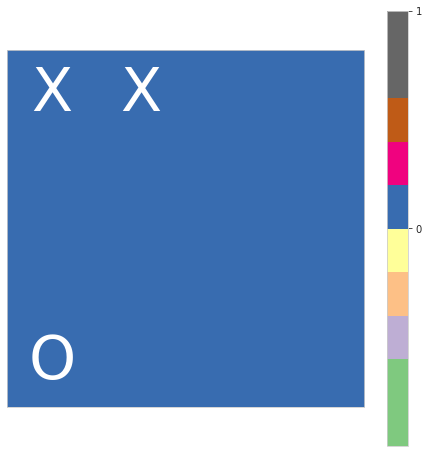

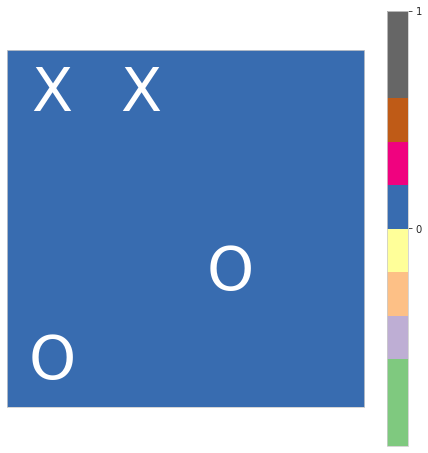

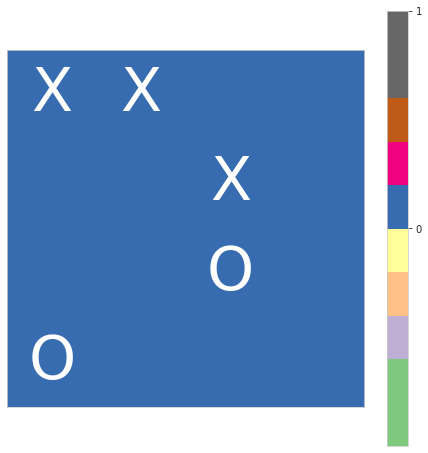

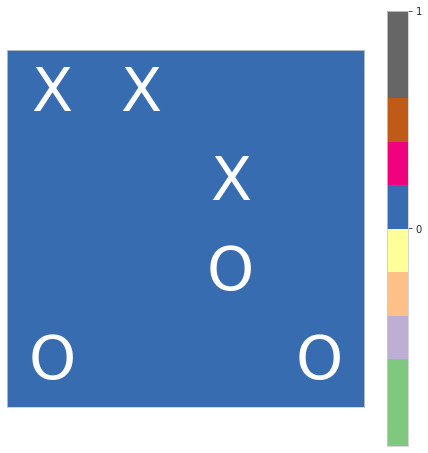

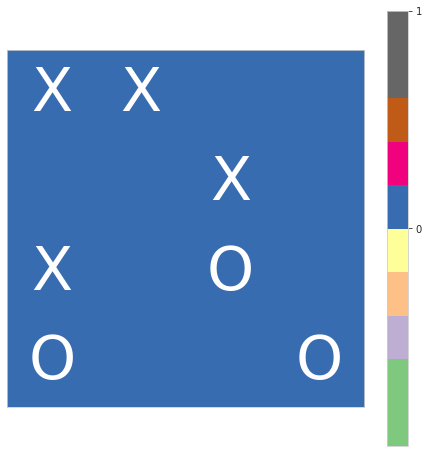

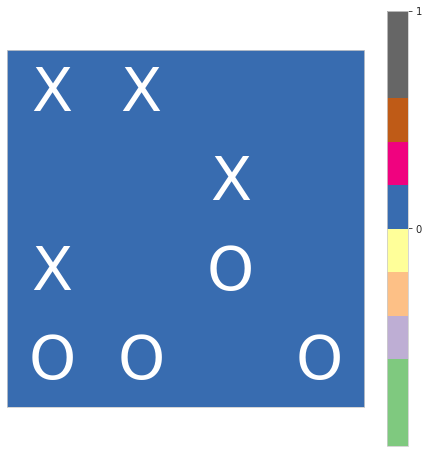

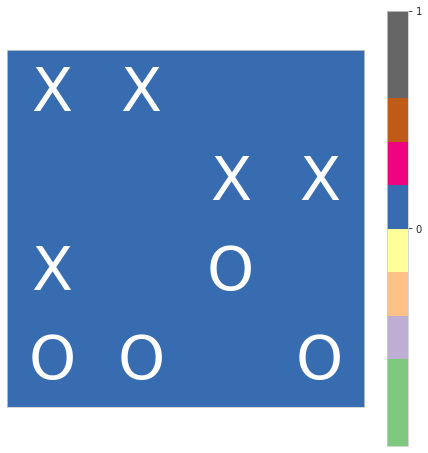

Нолики выиграли!


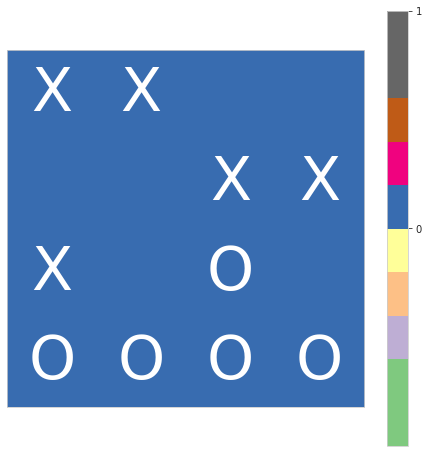

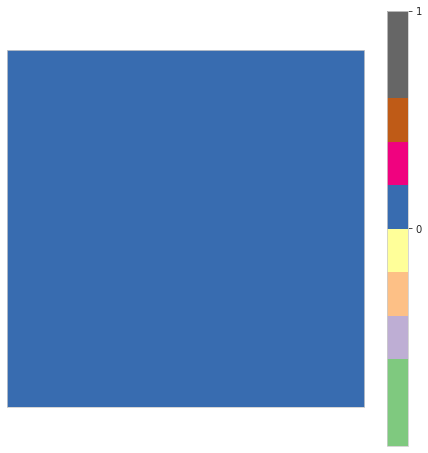

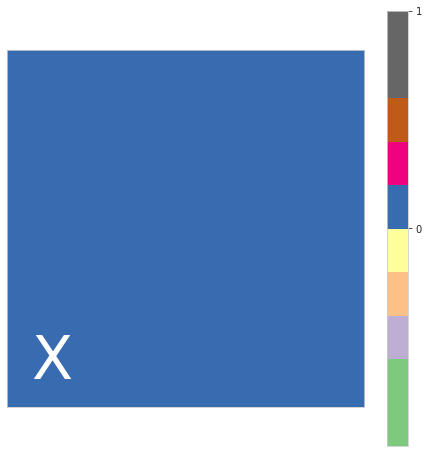

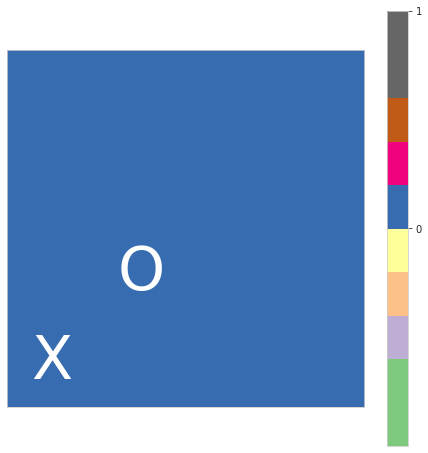

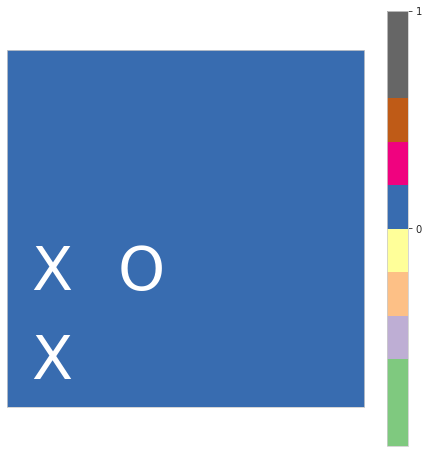

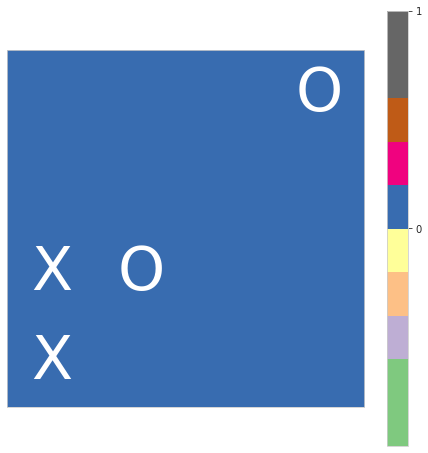

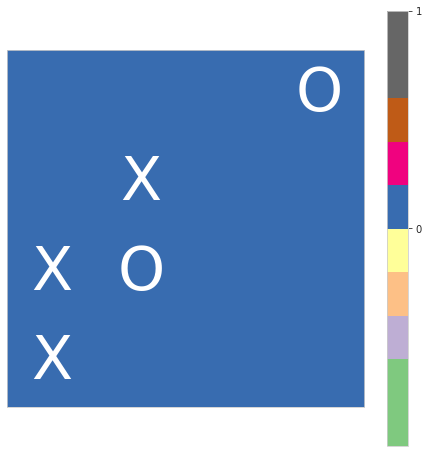

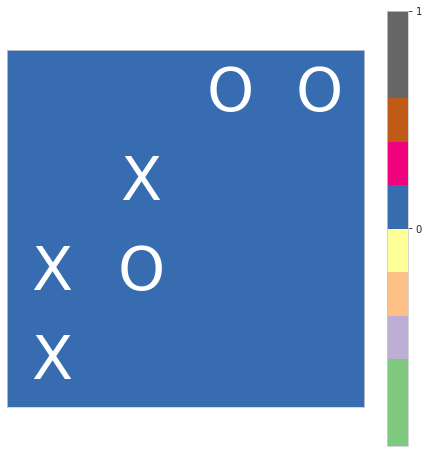

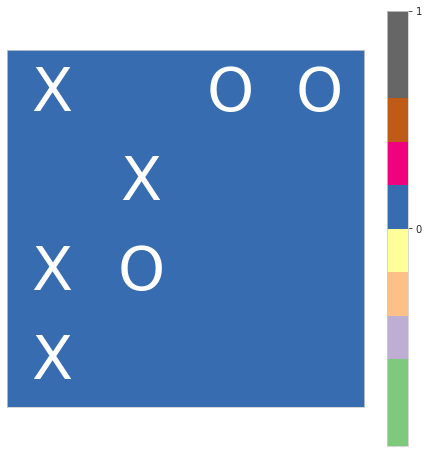

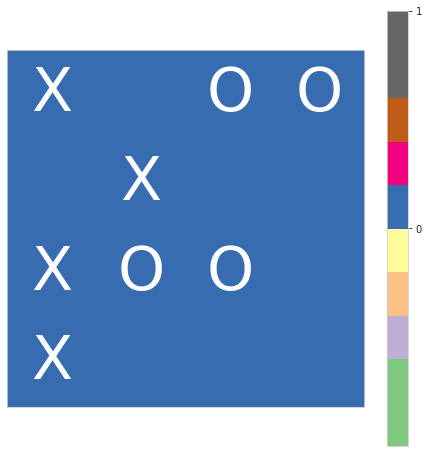

Крестики выиграли!


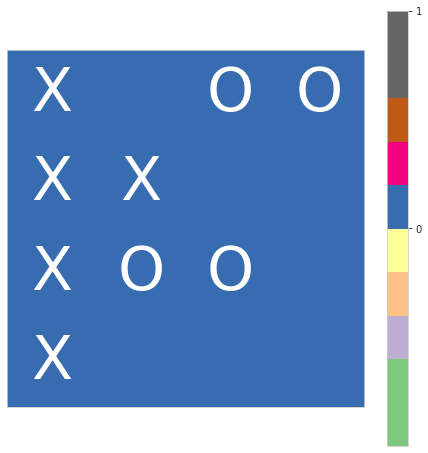

In [41]:
plot_test_game(env, crosses_policy_ddqlp, None, random_crosses=False, random_naughts=True)

plot_test_game(env, None, noughts_policy_ddqlp, random_crosses=True, random_naughts=False)

plot_test_game(env, crosses_policy_ddqlp, noughts_policy_ddqlp, random_crosses=False, random_naughts=False)

### Часть третья: расширим и углубим поиск

5. Реализуйте rollouts со случайной стратегией и (опционально) rollouts с неслучайной, но простой стратегией (например, основанной на дополнении нескольких паттернов или на Q-функции, которая у вас получилась в первом пункте).

In [159]:
class MCTS:
    def __init__(self, node, simulations_number):
        self.root = node
        self.simulations_number = simulations_number

    def best_action(self):
        for _ in range(self.simulations_number):            
            if not self.root.env.gameOver:
                v = self._tree_policy()
                reward = v.rollout()
                v.backpropagate(reward)
        steps_weights = self.root.get_steps_weights(c_param=0)
        return self.root.env.getEmptySpaces()[np.argmax(steps_weights)]

    def _tree_policy(self):
        current_node = self.root
        while not current_node.is_terminal_node():
            if not current_node.is_fully_expanded():
                return current_node.expand()
            else:
                current_node = current_node.best_child()
        return current_node  
    
class Node:
    def __init__(self, env, parent=None):
        self.env = deepcopy(env)
        self.parent = parent
        self.children = []
        self._number_of_visits = 0
        self._results = defaultdict(int)
        self._untried_actions = None
        self._reward = None

    def untried_actions(self):
        if self._untried_actions is None:
            self._untried_actions = list(self.env.getEmptySpaces())
        return self._untried_actions

    def q(self):
        wins = self._results[self.parent.env.curTurn]
        loses = self._results[-1 * self.parent.env.curTurn]
        return wins - loses

    def expand(self):
        action = self.untried_actions().pop()
        next_env = deepcopy(self.env)
        next_env.step(action)
        child_node = Node(
            next_env, parent=self
        )
        self.children.append(child_node)
        return child_node
    
    def is_terminal_node(self):
        return self.env.gameOver

    def rollout(self):
        current_rollout_env = deepcopy(self.env)
        while not current_rollout_env.gameOver:
            steps = list(current_rollout_env.getEmptySpaces())
            action = steps[np.random.randint(len(steps))]
            _, reward_, done, _  = current_rollout_env.step(action)
            self._reward = reward_
        return self._reward

    def backpropagate(self, result):
        self._number_of_visits += 1
        self._results[result] += 1
        if self.parent:
            self.parent.backpropagate(result)
            
    def is_fully_expanded(self):
        return len(self.untried_actions()) == 0
    
    def get_steps_weights(self, c_param):
        choices_weights = [
            (c.q() / c._number_of_visits) + c_param *
            np.sqrt((2 * np.log(self._number_of_visits) / c._number_of_visits))
            for c in self.children
        ]
        return choices_weights

    def best_child(self, c_param=1.4):
        choices_weights = self.get_steps_weights(c_param)
        return self.children[np.argmax(choices_weights)]

In [167]:
def get_action_q(env, q_policy):
    other_observation, other_actions = env.getHash(), env.getEmptySpaces()
    return q_policy.action(other_observation, other_actions, train_mode=True)

def get_action_mcts(env):
    mcts_agent = MCTS(Node(env=env), 1000)
    return mcts_agent.best_action()

get_action_q_crosses = partial(get_action_q, q_policy=crosses_q_learning_policy)
get_action_q_noughts = partial(get_action_q, q_policy=noughts_q_learning_policy)

In [168]:
n_rows = 3
n_cols = 3
n_win = 3

env = TicTacToe(n_rows=n_rows, n_cols=n_cols, n_win=n_win)

In [169]:
def mcts_estimation(policy1, policy2, games_num=30):
    res = []
    for _ in notebook.tqdm(range(games_num)):
        env.reset()
        done = False
        while True:
            action1 = policy1(env)
            _, reward, done, _ = env.step(action1)
            if done:
                res.append(reward)
                break
                
            action2 = policy2(env)
            _, reward, done, _ = env.step(action2)
            if done:
                res.append(reward)
                break
    return res

In [170]:
rewards = mcts_estimation(get_action_mcts, get_action_q_noughts)
np.mean(rewards)

0.2

Алгоритм показывает неплохое качество в базовом варианте при игре с натренированным q-learning алгоритом.
Если использовать в качестве rollout алгоритм противника, то можно с легкость у него выигрывать

6. Реализуйте MCTS-поиск с этими rollouts для крестиков-ноликов на досках разного размера, сравните полученные стратегии между собой и со стратегиями, обученными в первых двух частях.

In [185]:
def get_action_q(env, q_policy):
    other_observation, other_actions = env.getHash(), env.getEmptySpaces()
    return q_policy.action(other_observation, other_actions, train_mode=True)

def get_action_mcts(env):
    mcts_agent = MCTS(Node(env=env), 1000)
    return mcts_agent.best_action()

get_action_q_crosses_ = partial(get_action_q, q_policy=crosses_q_learning_policy_)
get_action_q_noughts_ = partial(get_action_q, q_policy=noughts_q_learning_policy_)

In [186]:
n_rows = 4
n_cols = 4
n_win = 4

env = TicTacToe(n_rows=n_rows, n_cols=n_cols, n_win=n_win)

In [187]:
rewards = mcts_estimation(get_action_mcts, get_action_q_noughts_)
np.mean(rewards)

-0.5

Против ноликов при том же фиксированном числе игр результат ожидаемо хуже